<a href="https://www.kaggle.com/code/pranaii/eda-fe-modelling-playground-series-s3-e12?scriptVersionId=138805510" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 0. Import libraries and settings

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import random as rnd
import plotly.express as px 
import math

from sklearn import datasets
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC

import datetime

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

sns.set(rc={"figure.dpi":100, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")
from IPython.display import set_matplotlib_formats
%config InlineBackend.figure_format = 'retina'
plt.style.use('tableau-colorblind10')

## About Dataset
This dataset can be used to predict the presence of kidney stones based on urine analysis.

The 79 urine specimens, were analyzed in an effort to
determine if certain physical characteristics of the urine might be related to the
formation of calcium oxalate crystals.
The six physical characteristics of the urine are: 
- (1) specific gravity, the density of the urine relative to water; 
- (2) pH, the negative logarithm of the hydrogen ion; 
- (3) osmolarity (mOsm), a unit used in biology and medicine but not in
physical chemistry. Osmolarity is proportional to the concentration of
molecules in solution; 
- (4) conductivity (mMho milliMho). One Mho is one
reciprocal Ohm. Conductivity is proportional to the concentration of charged
ions in solution;
- (5) urea concentration in millimoles per litre; and 
- (6) calcium concentration (CALC) in millimolesllitre.

The data is obtained from 'Physical Characteristics of Urines With and Without Crystals',a chapter from Springer Series in Statistics.

https://link.springer.com/chapter/10.1007/978-1-4612-5098-2_45

# 1. Data - how is it, data types, stats & more...

In [2]:
df_train = pd.read_csv('/kaggle/input/playground-series-s3e12/train.csv')
df_train

id  gravity    ph  osmo  cond  urea  calc  target
0      0    1.013  6.19   443  14.8   124  1.45       0
1      1    1.025  5.40   703  23.6   394  4.18       0
2      2    1.009  6.13   371  24.5   159  9.04       0
3      3    1.021  4.91   442  20.8   398  6.63       1
4      4    1.021  5.53   874  17.8   385  2.21       1
..   ...      ...   ...   ...   ...   ...   ...     ...
409  409    1.011  5.21   527  21.4    75  1.53       0
410  410    1.024  5.53   577  19.7   224  0.77       0
411  411    1.018  6.28   455  22.2   270  7.68       1
412  412    1.008  7.12   325  12.6    75  1.03       1
413  413    1.011  6.13   364   9.9   159  0.27       0

[414 rows x 8 columns]

### 1.1 Data types & Statistics of the data

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       414 non-null    int64  
 1   gravity  414 non-null    float64
 2   ph       414 non-null    float64
 3   osmo     414 non-null    int64  
 4   cond     414 non-null    float64
 5   urea     414 non-null    int64  
 6   calc     414 non-null    float64
 7   target   414 non-null    int64  
dtypes: float64(4), int64(4)
memory usage: 26.0 KB


- All of them are numerical columns.
- id is a unique key, so need to drop it.

In [4]:
df_train.describe().style.bar()

### 1.2 Target class distribution

Text(0.5, 1.0, 'Class distribution')

Text(0.5, 0, 'Class')

Text(0, 0.5, 'Count')

Text(0, 5, '230 (55.6 %)')

Text(0, 5, '184 (44.4 %)')

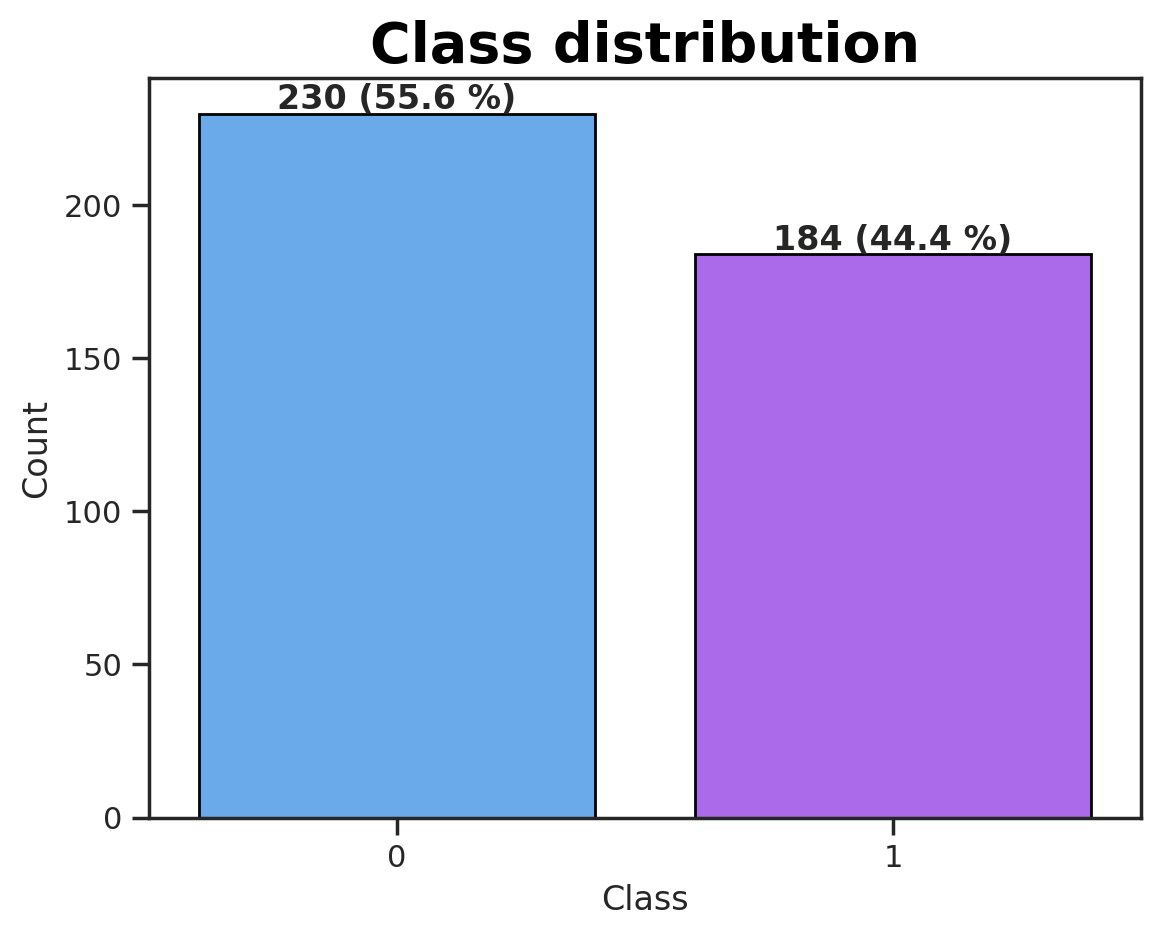

In [5]:
ax = sns.countplot(x="target",
                   edgecolor="black",
                   data=df_train,
                   palette="cool")
plt.title('Class distribution',
          fontdict={
              'fontsize': 20,
              'color': 'black',
              'fontweight': 'bold'
          })
plt.xlabel("Class")
plt.ylabel("Count")

for p in ax.patches:
    ax.annotate(
        format(p.get_height(), '.0f') + " (" + str(round(((p.get_height()/df_train.shape[0])*100), 1)) + " %)",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center',
                va='center',
                fontsize=12,
                fontweight='bold',
                xytext=(0, 5),
                textcoords='offset points')

- We see a little bias over 0 in target column.
- Our model could give more accurate results for target 0.

### 1.3 Duplicate and NaNs

In [6]:
cols = []
duplicate_values = []
duplicate_pct = []
nan_values = []
nan_pct = []

for i in df_train.columns:
    cols.append(i)
    nan_values.append(df_train[i].isnull().sum())
    nan_pct.append(
        round(((df_train[i].isnull().sum()) / df_train.shape[0]) * 100, 2))

    duplicate_values.append(df_train[i].duplicated().sum())
    duplicate_pct.append(
        round(((df_train[i].duplicated().sum()) / df_train.shape[0]) * 100, 2))

duplicate_and_nan_count = pd.DataFrame({
    "Column": cols,
    "Duplicate values": duplicate_values,
    "Duplicate %": duplicate_pct,
    "NaN values": nan_values,
    "NaN %": nan_pct
})
duplicate_and_nan_count

Column  Duplicate values  Duplicate %  NaN values  NaN %
0       id                 0         0.00           0    0.0
1  gravity               386        93.24           0    0.0
2       ph               343        82.85           0    0.0
3     osmo               334        80.68           0    0.0
4     cond               349        84.30           0    0.0
5     urea               341        82.37           0    0.0
6     calc               329        79.47           0    0.0
7   target               412        99.52           0    0.0

In [7]:
# Just confirming the values in above table are right or not.

((df_train.shape[0] - df_train['gravity'].nunique()) / df_train.shape[0]) * 100
((df_train.shape[0] - df_train['target'].nunique()) / df_train.shape[0]) * 100

93.23671497584542

99.51690821256038

In [8]:
duplicate_and_nan_count.index = duplicate_and_nan_count.Column.values
duplicate_and_nan_count.drop(['Column'], axis=1, inplace=True)
duplicate_and_nan_count

Duplicate values  Duplicate %  NaN values  NaN %
id                      0         0.00           0    0.0
gravity               386        93.24           0    0.0
ph                    343        82.85           0    0.0
osmo                  334        80.68           0    0.0
cond                  349        84.30           0    0.0
urea                  341        82.37           0    0.0
calc                  329        79.47           0    0.0
target                412        99.52           0    0.0

### 1.4 Visualizing NaNs and Duplicate values

Text(0.5, 1.0, 'NaNs and Duplicate percentage')

Text(0.5, 0, 'Column')

Text(0, 0.5, 'Percentage')

Text(0, 5, '0.0')

Text(0, 5, '93.2')

Text(0, 5, '82.8')

Text(0, 5, '80.7')

Text(0, 5, '84.3')

Text(0, 5, '82.4')

Text(0, 5, '79.5')

Text(0, 5, '99.5')

Text(0, 5, '0.0')

Text(0, 5, '0.0')

Text(0, 5, '0.0')

Text(0, 5, '0.0')

Text(0, 5, '0.0')

Text(0, 5, '0.0')

Text(0, 5, '0.0')

Text(0, 5, '0.0')

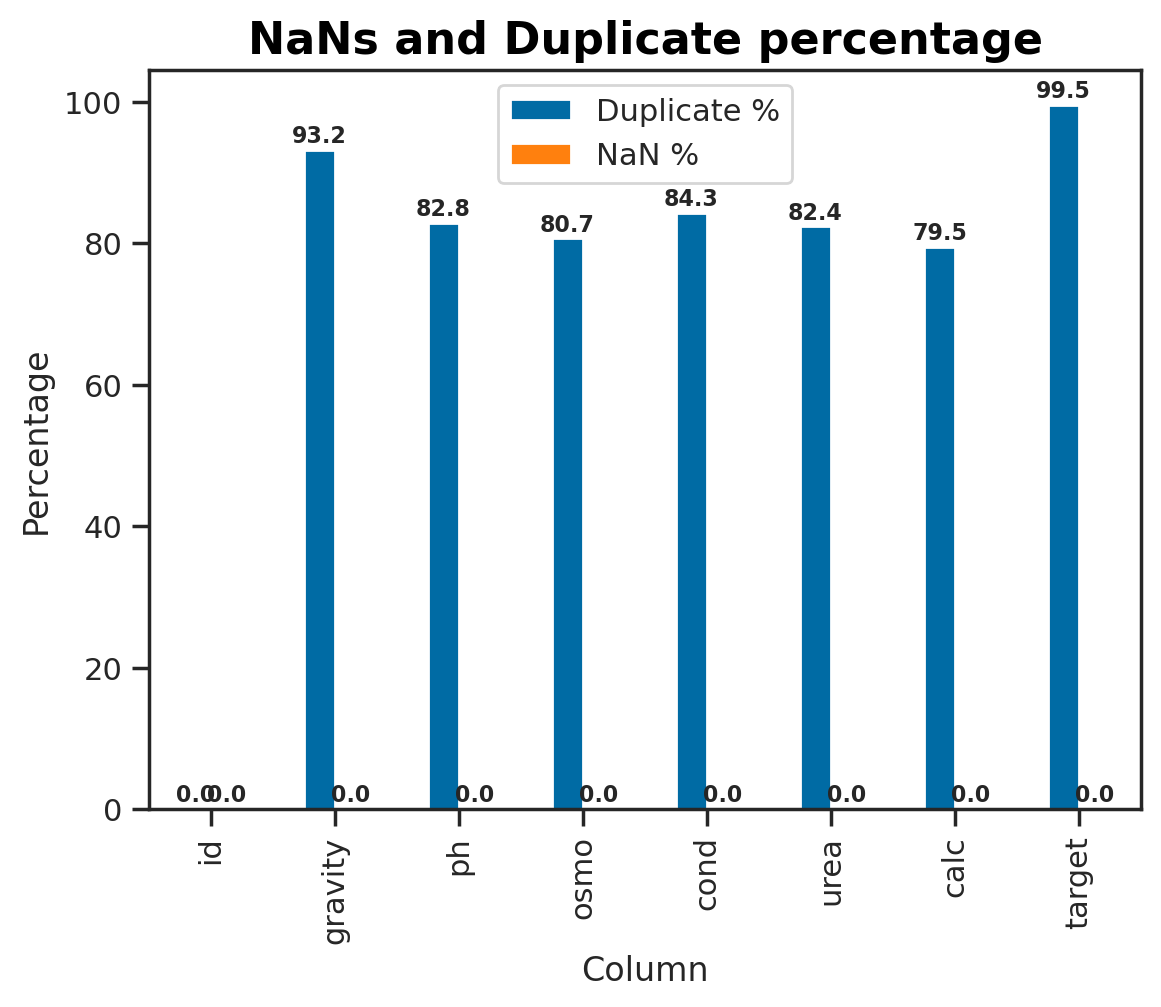

In [9]:
ax = duplicate_and_nan_count[['Duplicate %', 'NaN %']].plot.bar()
plt.title('NaNs and Duplicate percentage',
          fontdict={
              'fontsize': 16,
              'color': 'black',
              'fontweight': 'bold'
          })
plt.xlabel("Column")
plt.ylabel("Percentage")
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center',
                va='center',
                fontsize=8,
                fontweight='bold',
                xytext=(0, 5),
                textcoords='offset points')

### 1.5 # of unique values in each column

In [10]:
column_unique = dict()
for i in df_train.columns:
    column_unique[i] = df_train[i].nunique()
column_unique = pd.Series(column_unique)
column_unique

id         414
gravity     28
ph          71
osmo        80
cond        65
urea        73
calc        85
target       2
dtype: int64

Text(0.5, 1.0, 'No. of unique values - column wise')

Text(0.5, 0, 'Column')

Text(0, 0.5, 'Count')

Text(0, 5, '414')

Text(0, 5, '28')

Text(0, 5, '71')

Text(0, 5, '80')

Text(0, 5, '65')

Text(0, 5, '73')

Text(0, 5, '85')

Text(0, 5, '2')

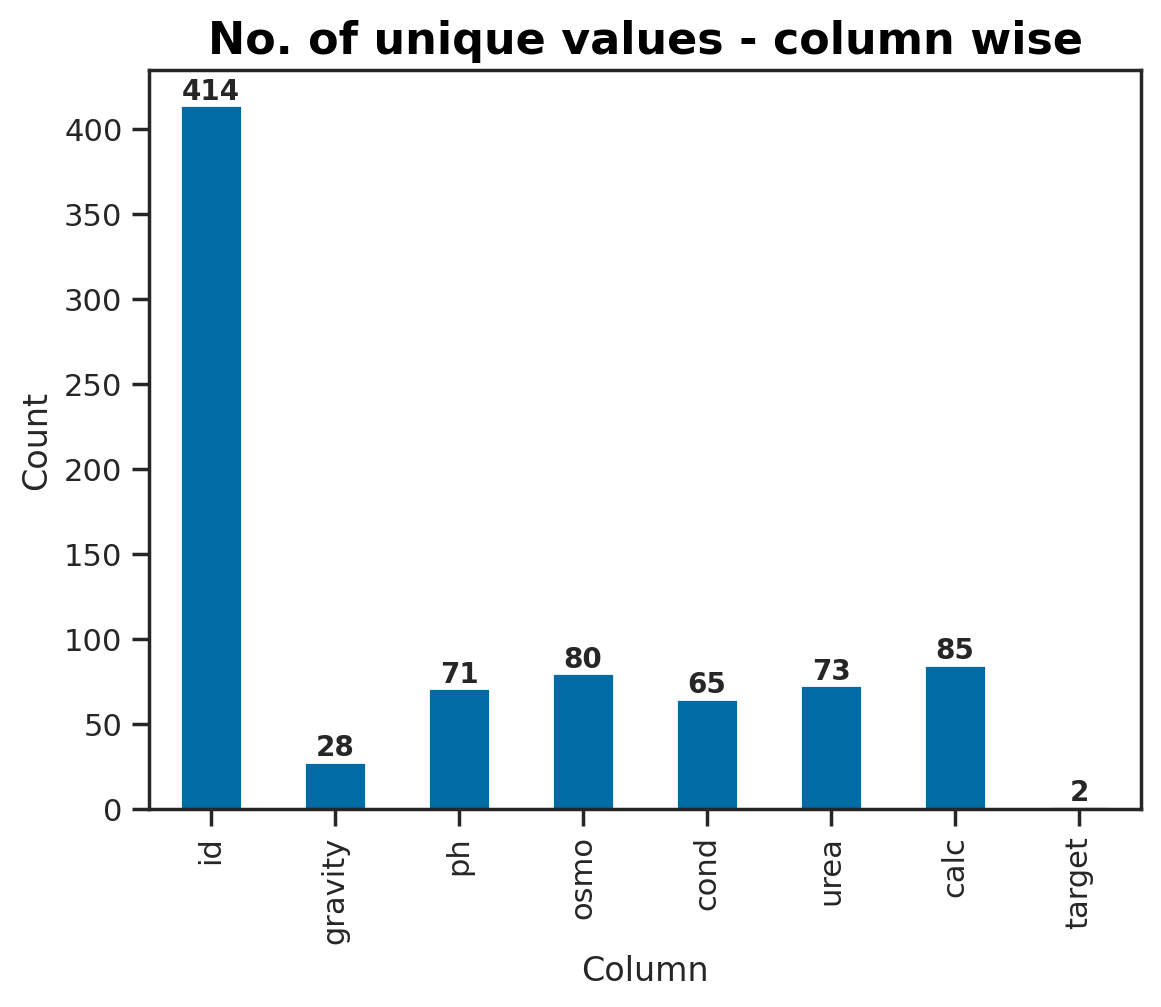

In [11]:
ax = column_unique.plot.bar()       
plt.title('No. of unique values - column wise',
          fontdict={
              'fontsize': 16,
              'color': 'black',
              'fontweight': 'bold'
          })
plt.xlabel("Column")
plt.ylabel("Count")
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center',
                va='center',
                fontsize=10,
                fontweight='bold',
                xytext=(0, 5),
                textcoords='offset points')

In [12]:
# Dropping id

df_train.drop(columns = ['id'], axis = 1, inplace = True)

In [13]:
df_train

gravity    ph  osmo  cond  urea  calc  target
0      1.013  6.19   443  14.8   124  1.45       0
1      1.025  5.40   703  23.6   394  4.18       0
2      1.009  6.13   371  24.5   159  9.04       0
3      1.021  4.91   442  20.8   398  6.63       1
4      1.021  5.53   874  17.8   385  2.21       1
..       ...   ...   ...   ...   ...   ...     ...
409    1.011  5.21   527  21.4    75  1.53       0
410    1.024  5.53   577  19.7   224  0.77       0
411    1.018  6.28   455  22.2   270  7.68       1
412    1.008  7.12   325  12.6    75  1.03       1
413    1.011  6.13   364   9.9   159  0.27       0

[414 rows x 7 columns]

# 2. Column wise distributions (Univariate analysis) + removing outliers

### 2.0 Defining helper function

In [14]:
def plot_hist_box_violin(dataframe, column, bins, hue):
    fig, (ax_box, ax_hist, ax_violin) = plt.subplots(
        3,
        1,
        figsize=(10, 6),
        sharex='col',
        gridspec_kw={"height_ratios": (.2, .5, .2)})
    sns.boxplot(data=dataframe, x=column, ax=ax_box, palette="cool")
    sns.histplot(data=dataframe,
                 x=column,
                 kde=True,
                 bins=bins,
                 ax=ax_hist,
                 hue=hue,
                 palette="cool")
    sns.rugplot(data=dataframe, x=column, ax=ax_hist, color='red')
    sns.violinplot(data=dataframe, x=column, ax=ax_violin, palette="cool")
    plt.tight_layout()

### 2.1 gravity

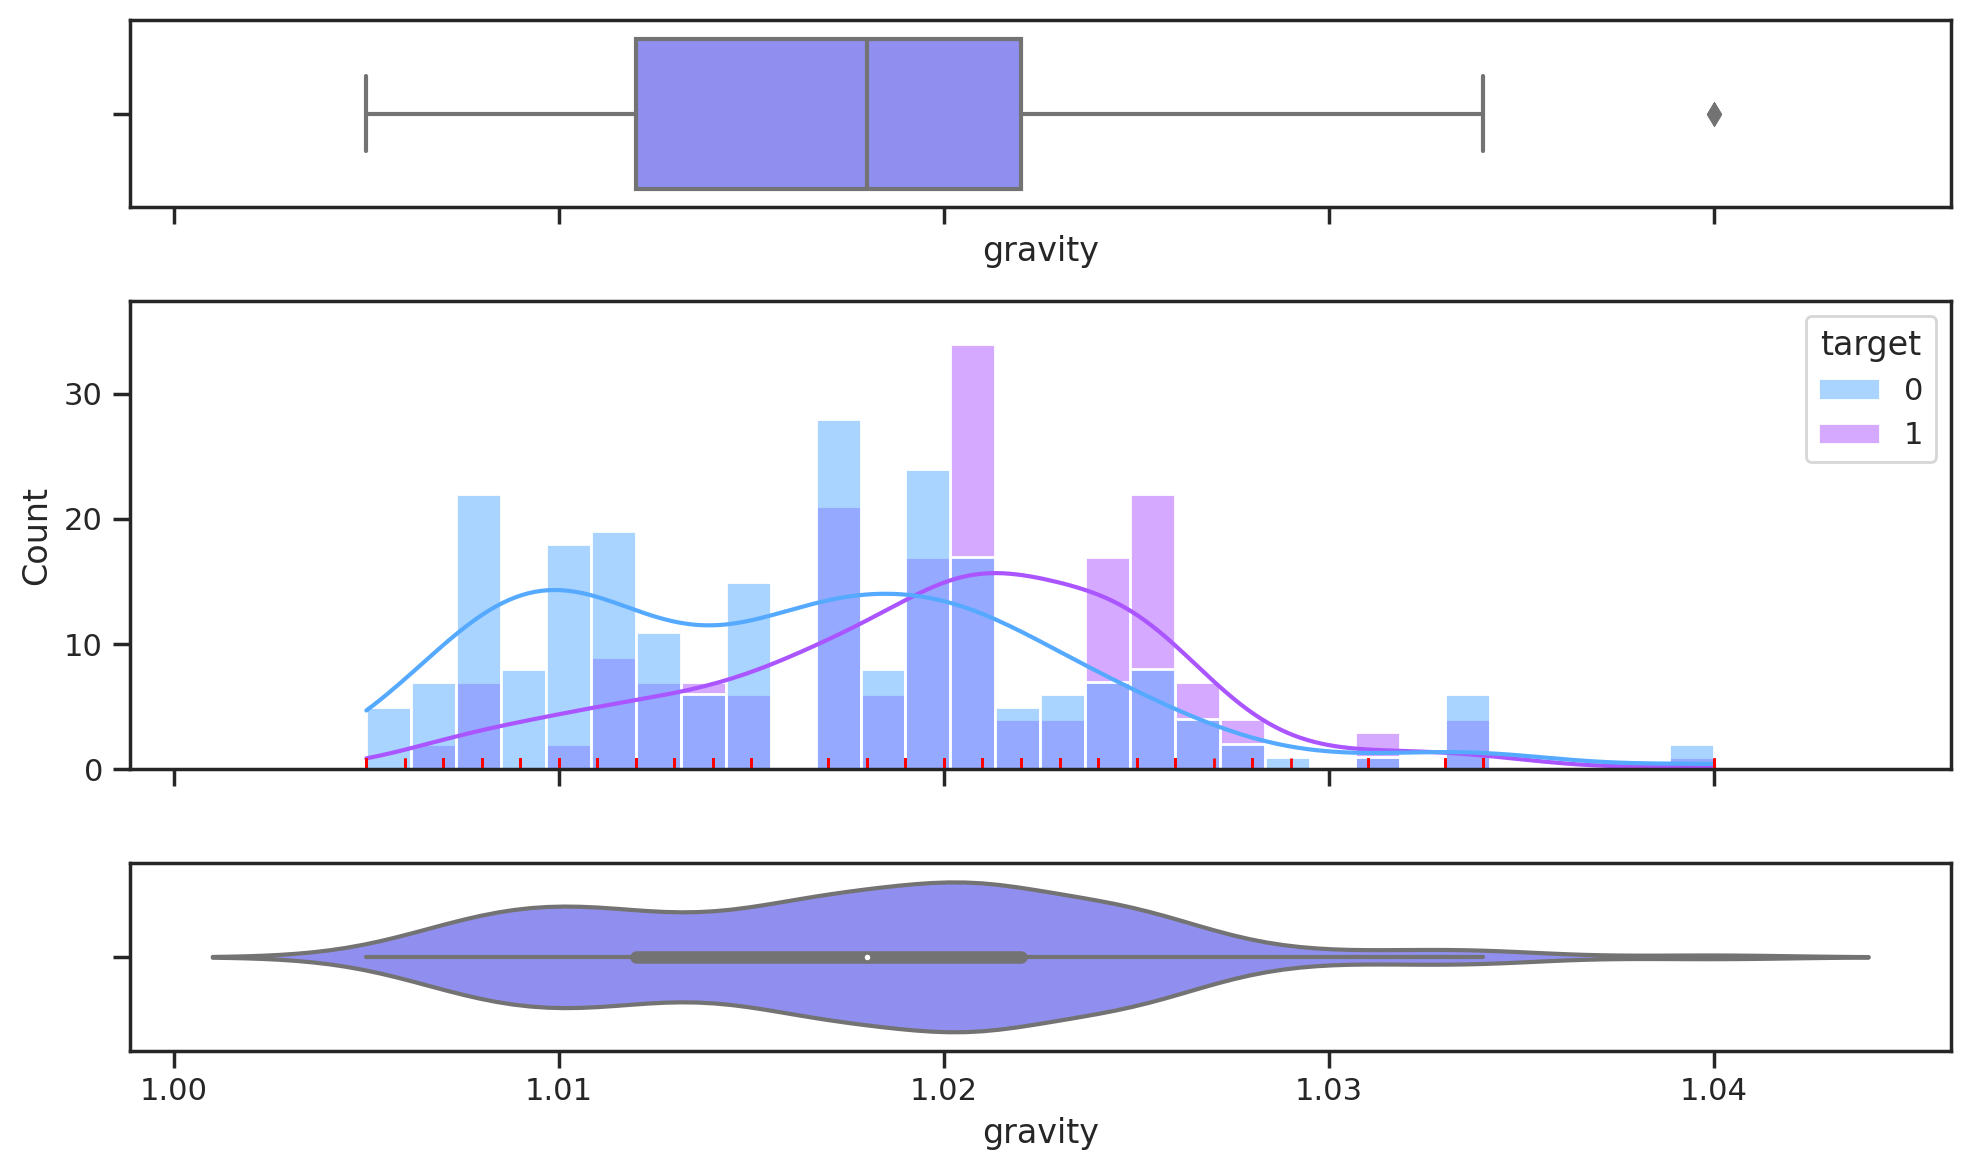

In [15]:
plot_hist_box_violin(df_train, 'gravity', 30, 'target')

- We don't see much of outliers except a point.
- There is no skewness which is good.

### 2.2 ph

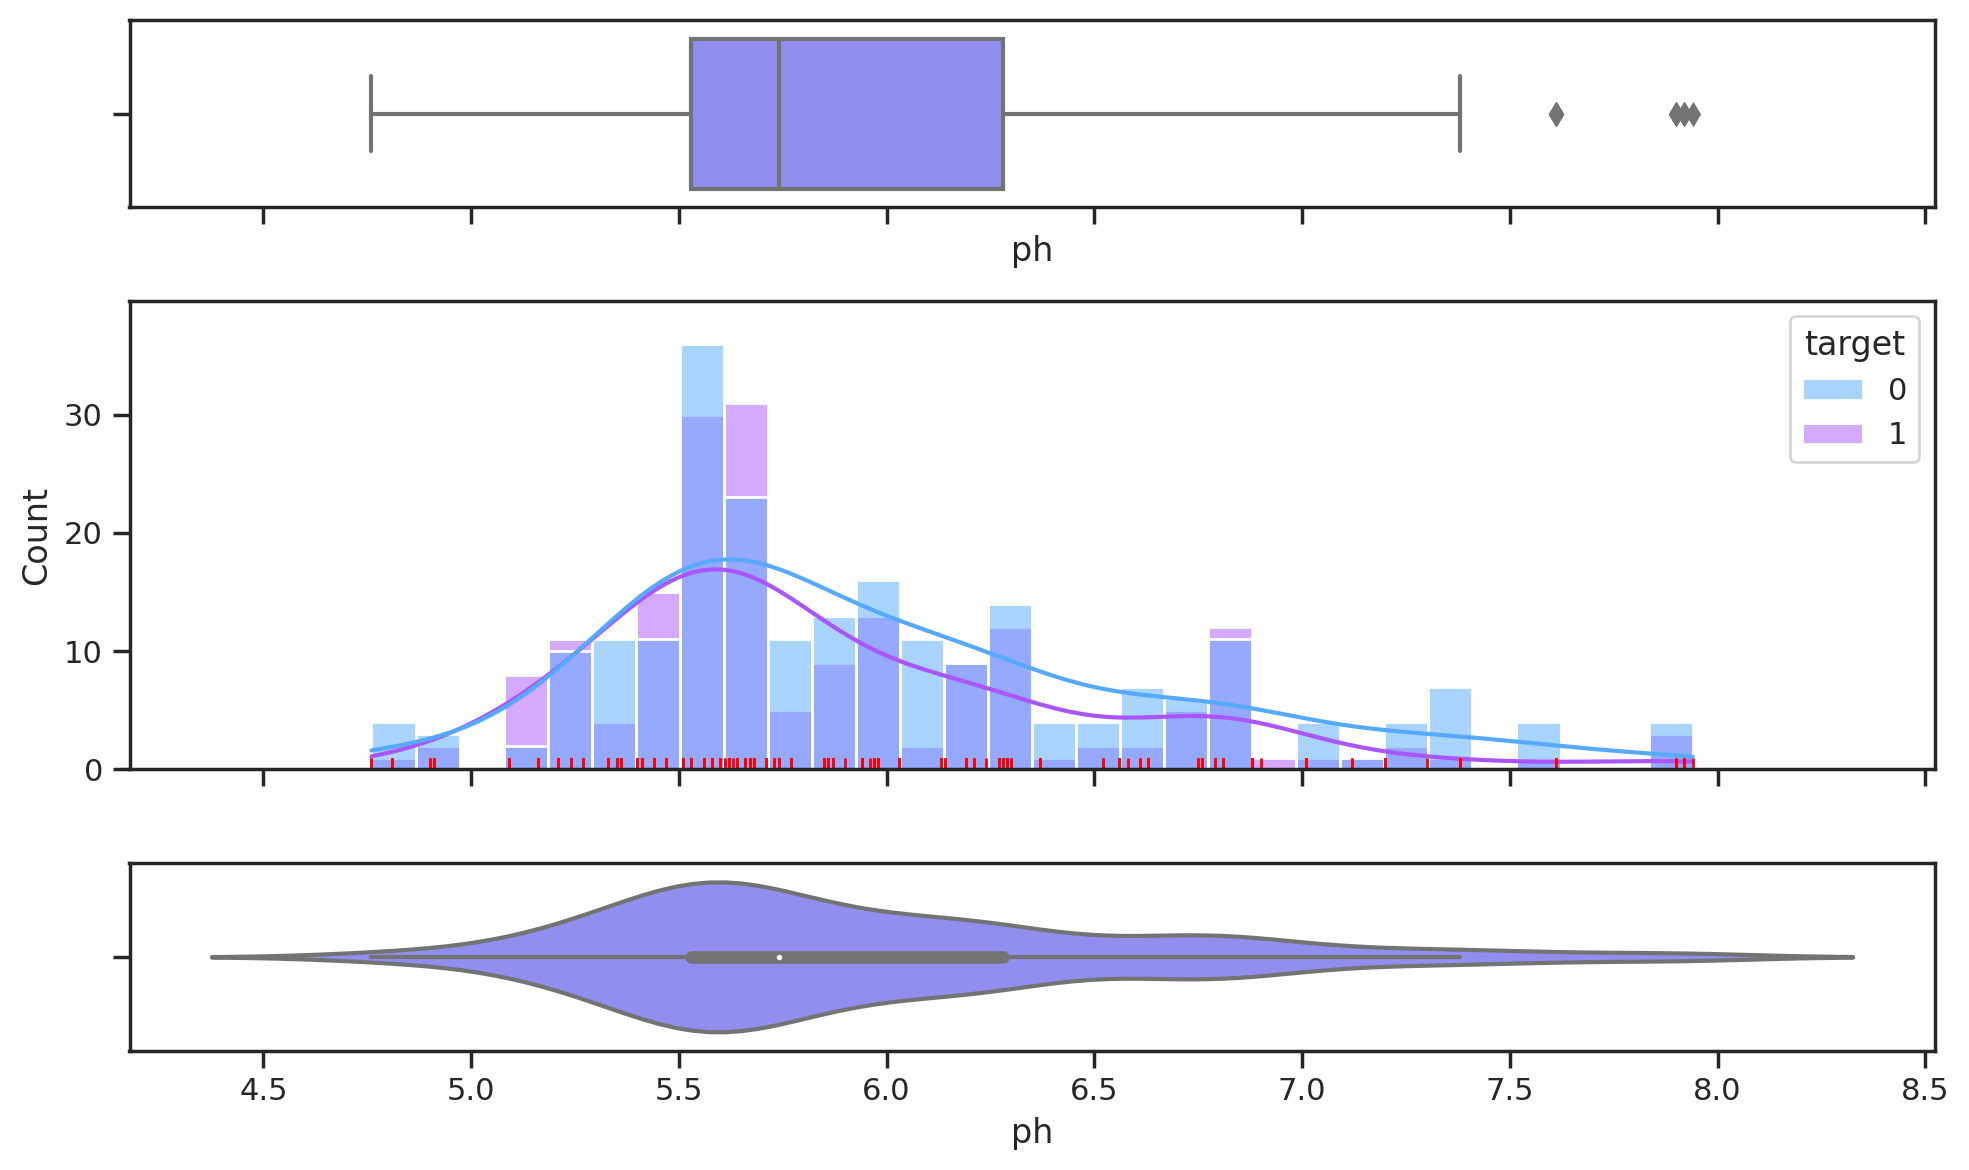

In [16]:
plot_hist_box_violin(df_train, 'ph', 30, 'target')

- We have few outliers.
- There is little right skewness which we can handle by removing the outliers.

In [17]:
from matplotlib.cbook import boxplot_stats
boxplot_stats(df_train['ph'])

[{'mean': 5.955458937198068,
  'iqr': 0.75,
  'cilo': 5.682129032209203,
  'cihi': 5.797870967790797,
  'whishi': 7.38,
  'whislo': 4.76,
  'fliers': array([7.61, 7.92, 7.61, 7.9 , 7.61, 7.94, 7.9 , 7.61, 7.92, 7.92, 7.61,
         7.9 ]),
  'q1': 5.53,
  'med': 5.74,
  'q3': 6.28}]

In [18]:
df_train[df_train['ph'] >= boxplot_stats(df_train['ph'])[0]['whishi']]
df_train[df_train['ph'] >= boxplot_stats(df_train['ph'])[0]['whishi']].shape

gravity    ph  osmo  cond  urea   calc  target
8      1.025  7.38   736  25.3   418   1.52       0
17     1.012  7.38   760  25.7   199   1.05       0
32     1.017  7.61   527  21.4    75   2.17       0
58     1.022  7.92   907  26.1   443   4.49       0
104    1.017  7.61   527  25.8    75   3.98       0
105    1.014  7.38   721  25.8   301   2.45       1
139    1.018  7.38   704  23.6   270   1.27       0
141    1.008  7.38   577  26.0    87   1.03       0
177    1.020  7.90   668  23.6   252   3.98       1
197    1.010  7.38   577  25.7    75   2.31       0
201    1.018  7.61   527  20.8    75   3.98       1
233    1.020  7.94  1236  25.3   620   3.46       0
255    1.025  7.90   721  23.6   301  12.20       0
323    1.017  7.61   527  23.6    75   1.16       0
361    1.011  7.38   187  10.9    87   1.93       0
362    1.017  7.92   680  25.3   282   3.46       1
364    1.017  7.38   527  25.3    87   1.06       0
370    1.015  7.92   531  20.8   187   3.16       1
377    1.010  7.61   527  25.8    75   1.27       0
388    1.011  7.90   395  24.5    95   1.53       0

(20, 7)

In [19]:
df_train.shape
df_train[~(df_train['ph'] >= boxplot_stats(df_train['ph'])[0]['whishi'])]

(414, 7)

gravity    ph  osmo  cond  urea  calc  target
0      1.013  6.19   443  14.8   124  1.45       0
1      1.025  5.40   703  23.6   394  4.18       0
2      1.009  6.13   371  24.5   159  9.04       0
3      1.021  4.91   442  20.8   398  6.63       1
4      1.021  5.53   874  17.8   385  2.21       1
..       ...   ...   ...   ...   ...   ...     ...
409    1.011  5.21   527  21.4    75  1.53       0
410    1.024  5.53   577  19.7   224  0.77       0
411    1.018  6.28   455  22.2   270  7.68       1
412    1.008  7.12   325  12.6    75  1.03       1
413    1.011  6.13   364   9.9   159  0.27       0

[394 rows x 7 columns]

In [20]:
df_train_old = df_train.copy() # Having a backup is always a good choice before modifying original dataframe.

df_train = df_train[~(df_train['ph'] >= boxplot_stats(df_train['ph'])[0]['whishi'])]
df_train

gravity    ph  osmo  cond  urea  calc  target
0      1.013  6.19   443  14.8   124  1.45       0
1      1.025  5.40   703  23.6   394  4.18       0
2      1.009  6.13   371  24.5   159  9.04       0
3      1.021  4.91   442  20.8   398  6.63       1
4      1.021  5.53   874  17.8   385  2.21       1
..       ...   ...   ...   ...   ...   ...     ...
409    1.011  5.21   527  21.4    75  1.53       0
410    1.024  5.53   577  19.7   224  0.77       0
411    1.018  6.28   455  22.2   270  7.68       1
412    1.008  7.12   325  12.6    75  1.03       1
413    1.011  6.13   364   9.9   159  0.27       0

[394 rows x 7 columns]

In [21]:
df_train_old

gravity    ph  osmo  cond  urea  calc  target
0      1.013  6.19   443  14.8   124  1.45       0
1      1.025  5.40   703  23.6   394  4.18       0
2      1.009  6.13   371  24.5   159  9.04       0
3      1.021  4.91   442  20.8   398  6.63       1
4      1.021  5.53   874  17.8   385  2.21       1
..       ...   ...   ...   ...   ...   ...     ...
409    1.011  5.21   527  21.4    75  1.53       0
410    1.024  5.53   577  19.7   224  0.77       0
411    1.018  6.28   455  22.2   270  7.68       1
412    1.008  7.12   325  12.6    75  1.03       1
413    1.011  6.13   364   9.9   159  0.27       0

[414 rows x 7 columns]

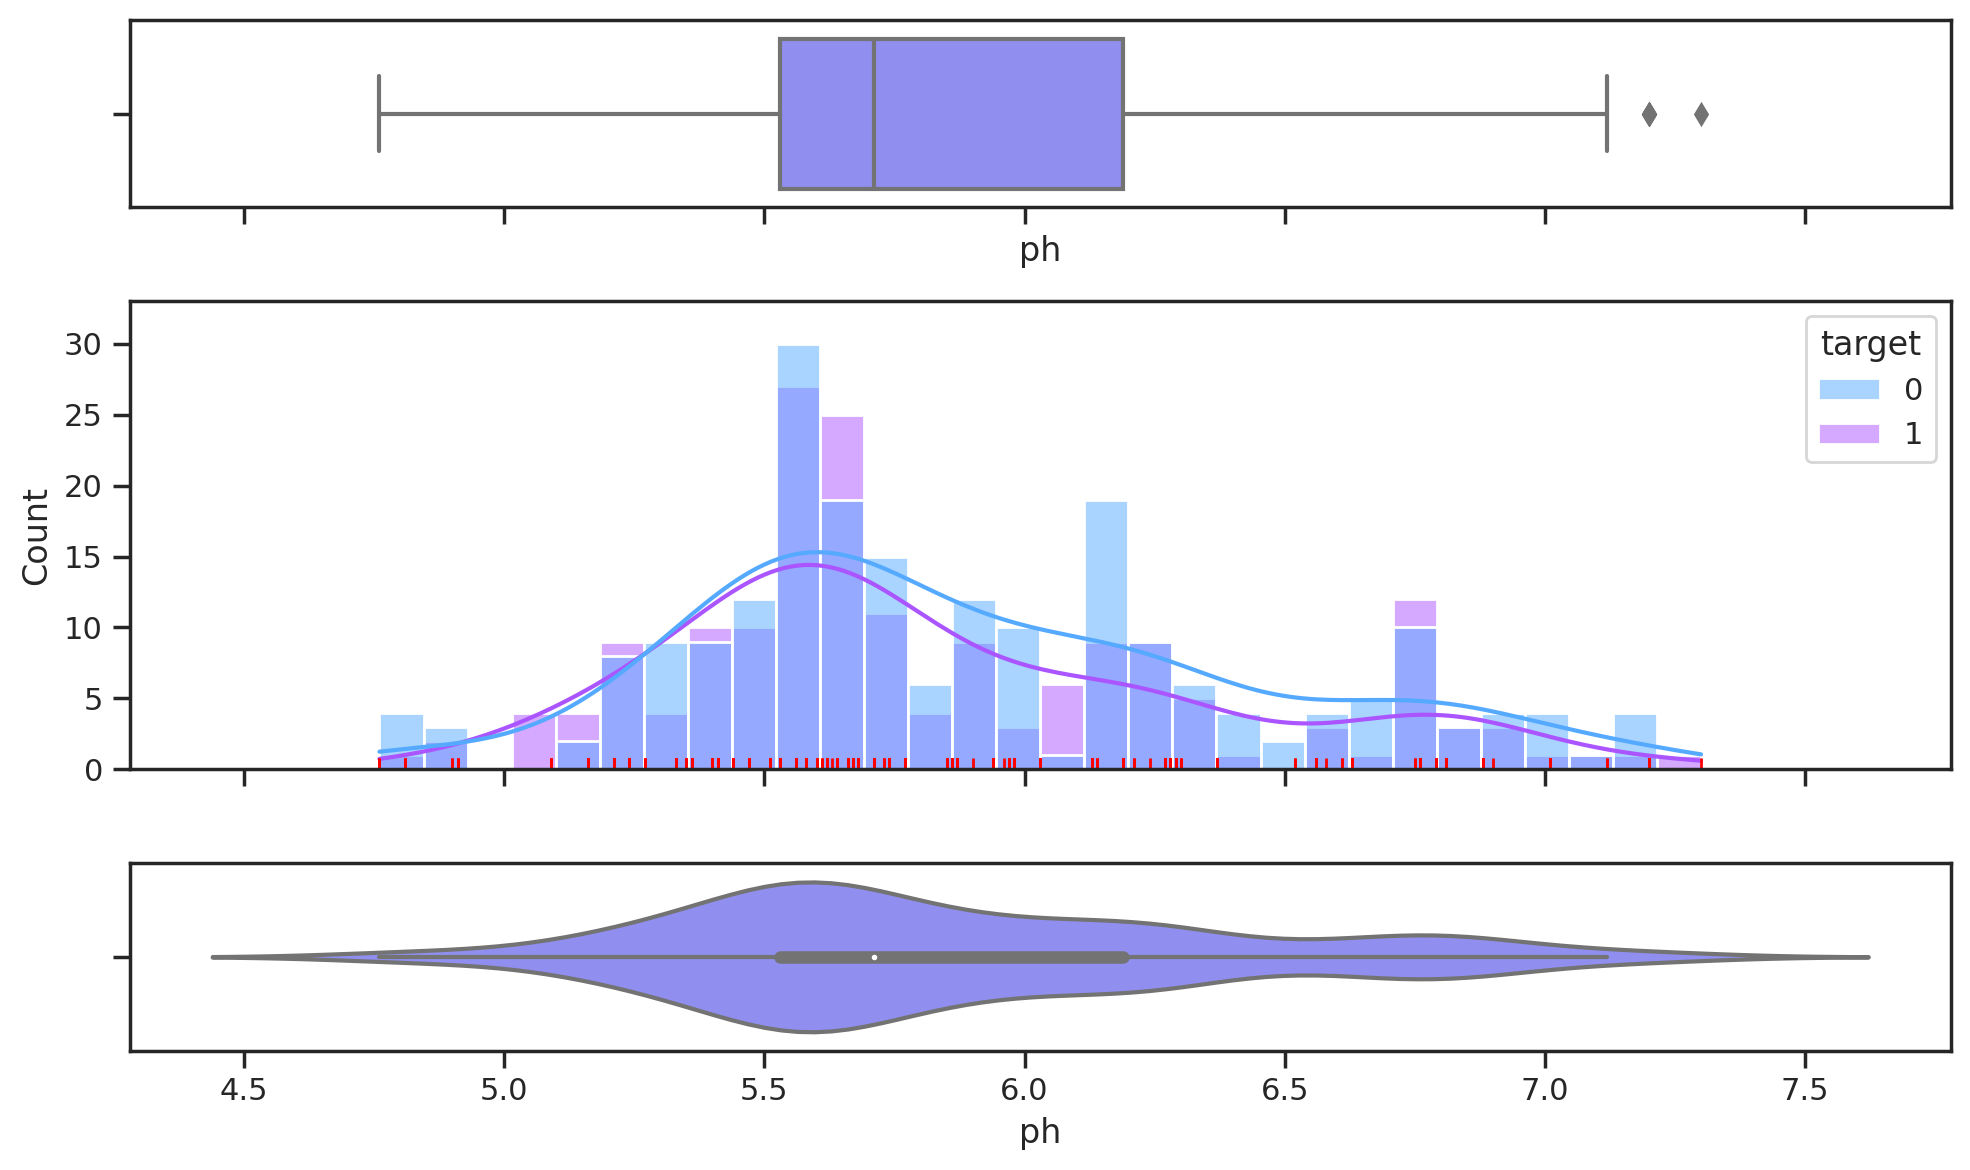

In [22]:
# Now plot
plot_hist_box_violin(df_train, 'ph', 30, 'target')

- Now we see lesser outliers.
- The skewness is less now.

### 2.3 osmo

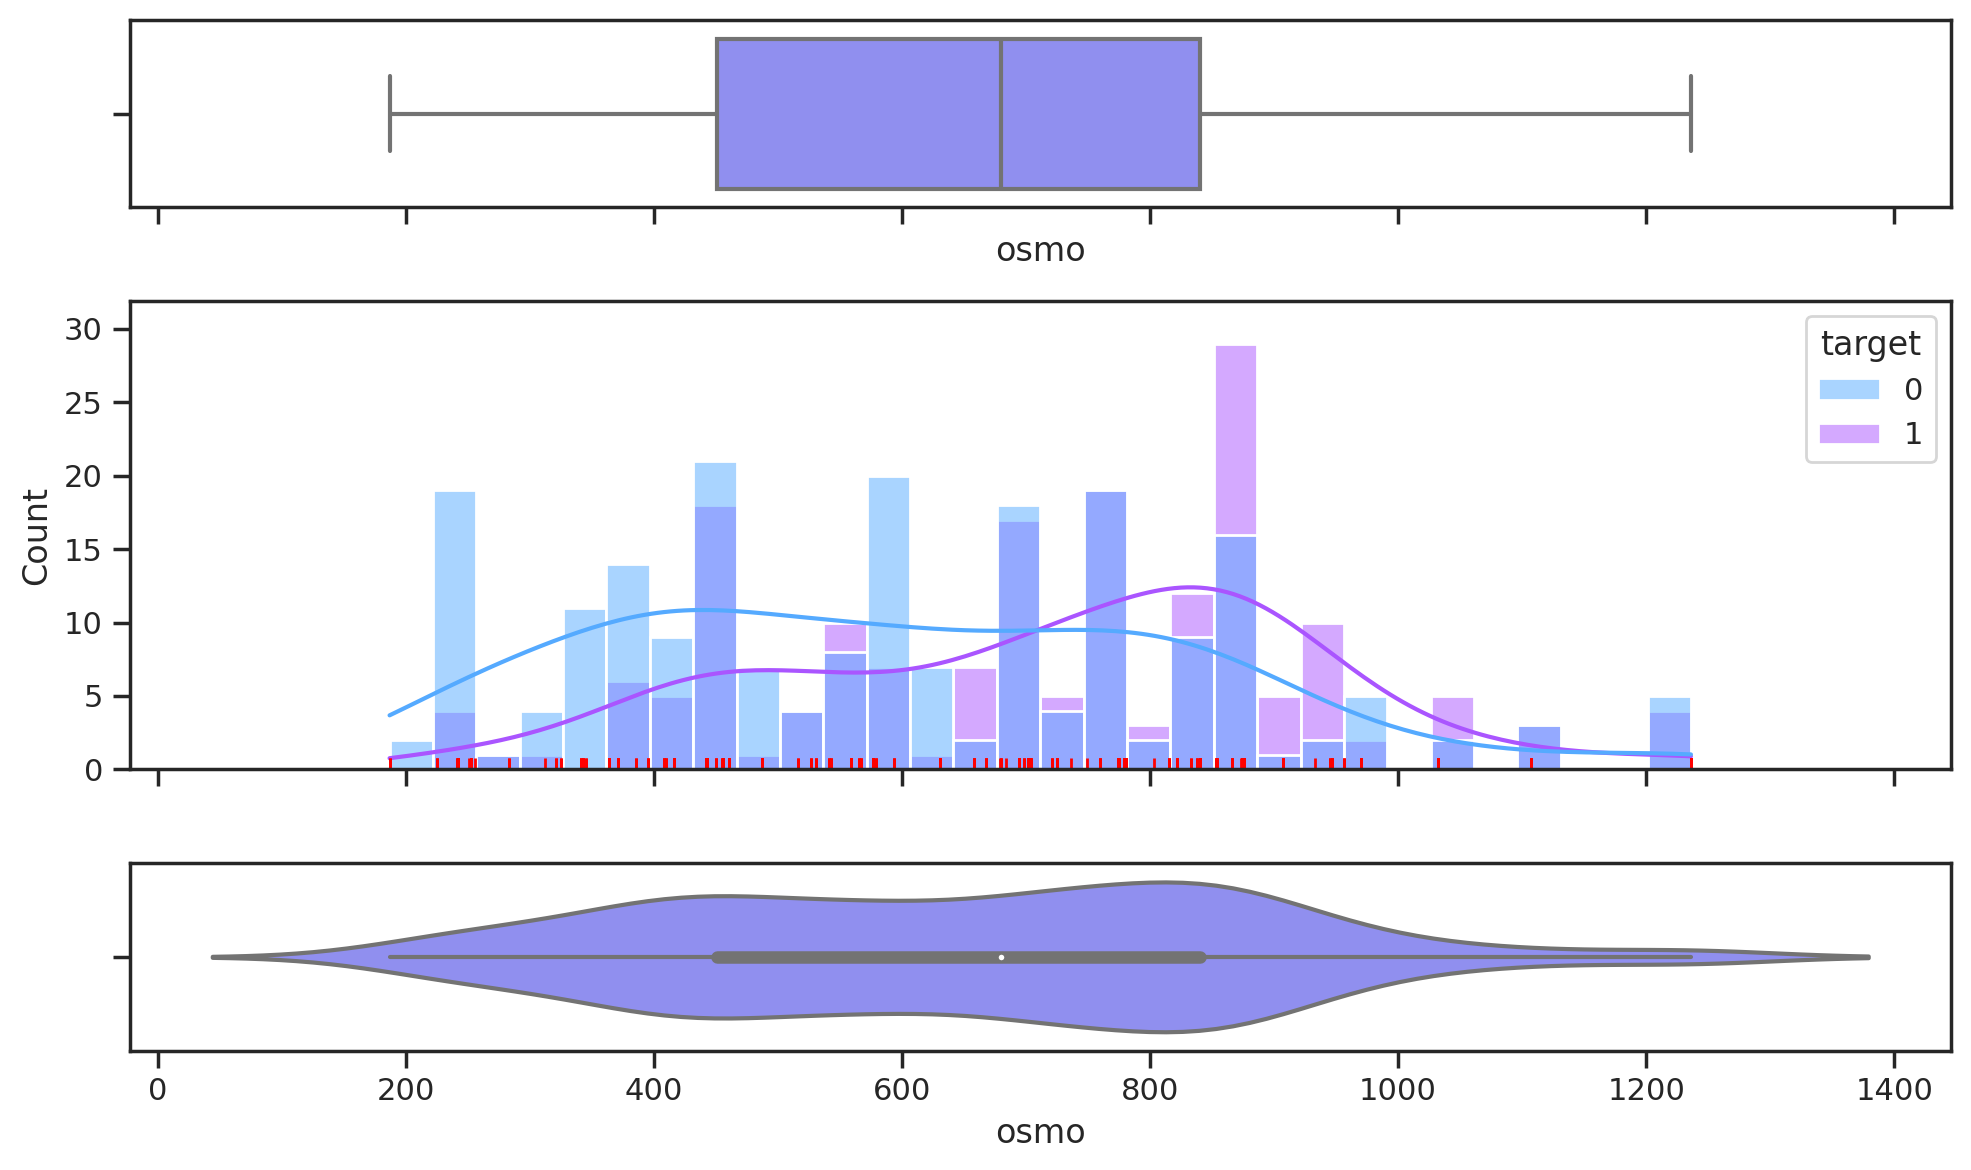

In [23]:
plot_hist_box_violin(df_train, 'osmo', 30, 'target')

- We don't see any outliers
- There is no skewness too.

### 2.4 cond

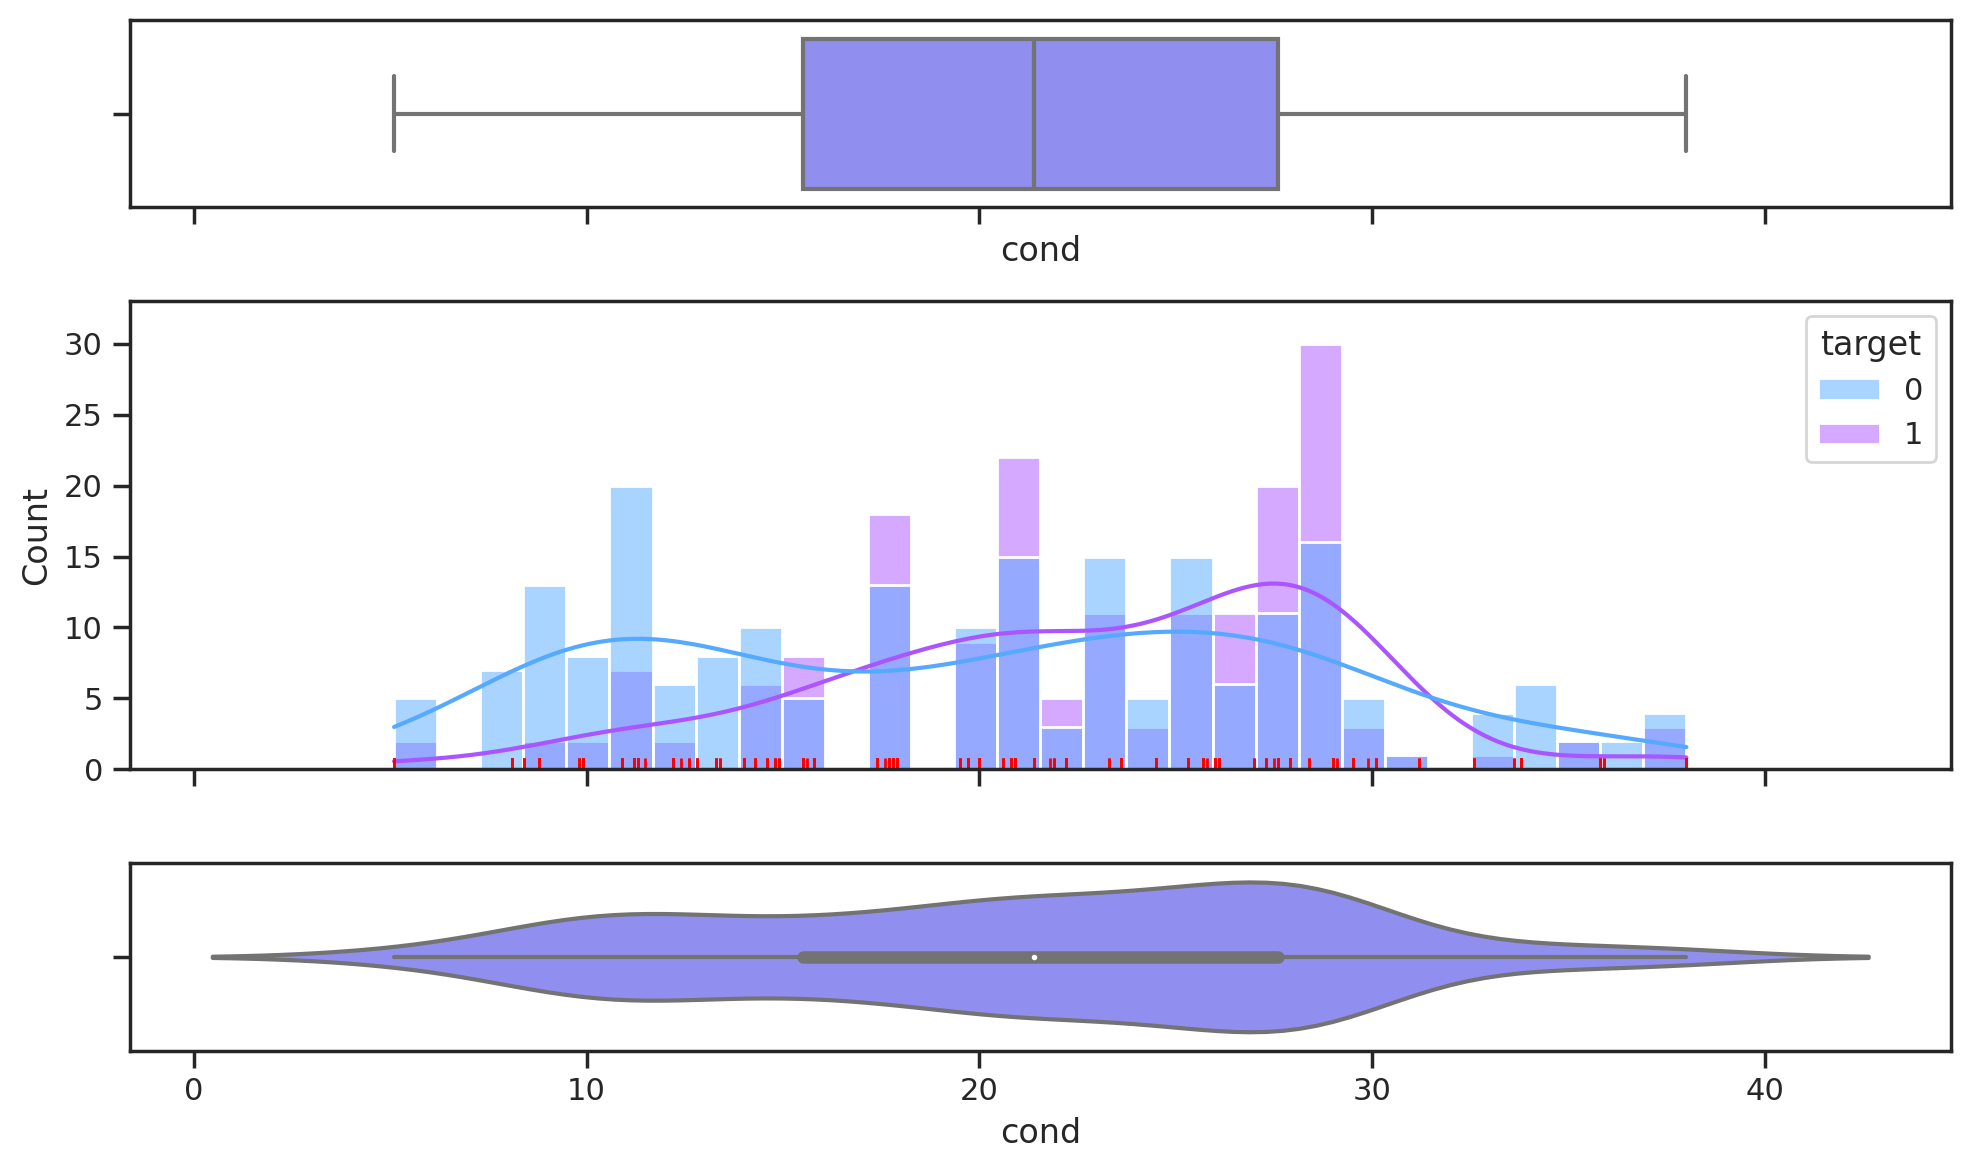

In [24]:
plot_hist_box_violin(df_train, 'cond', 30, 'target')

- We don't see any outliers
- There is no skewness too.

### 2.5 urea

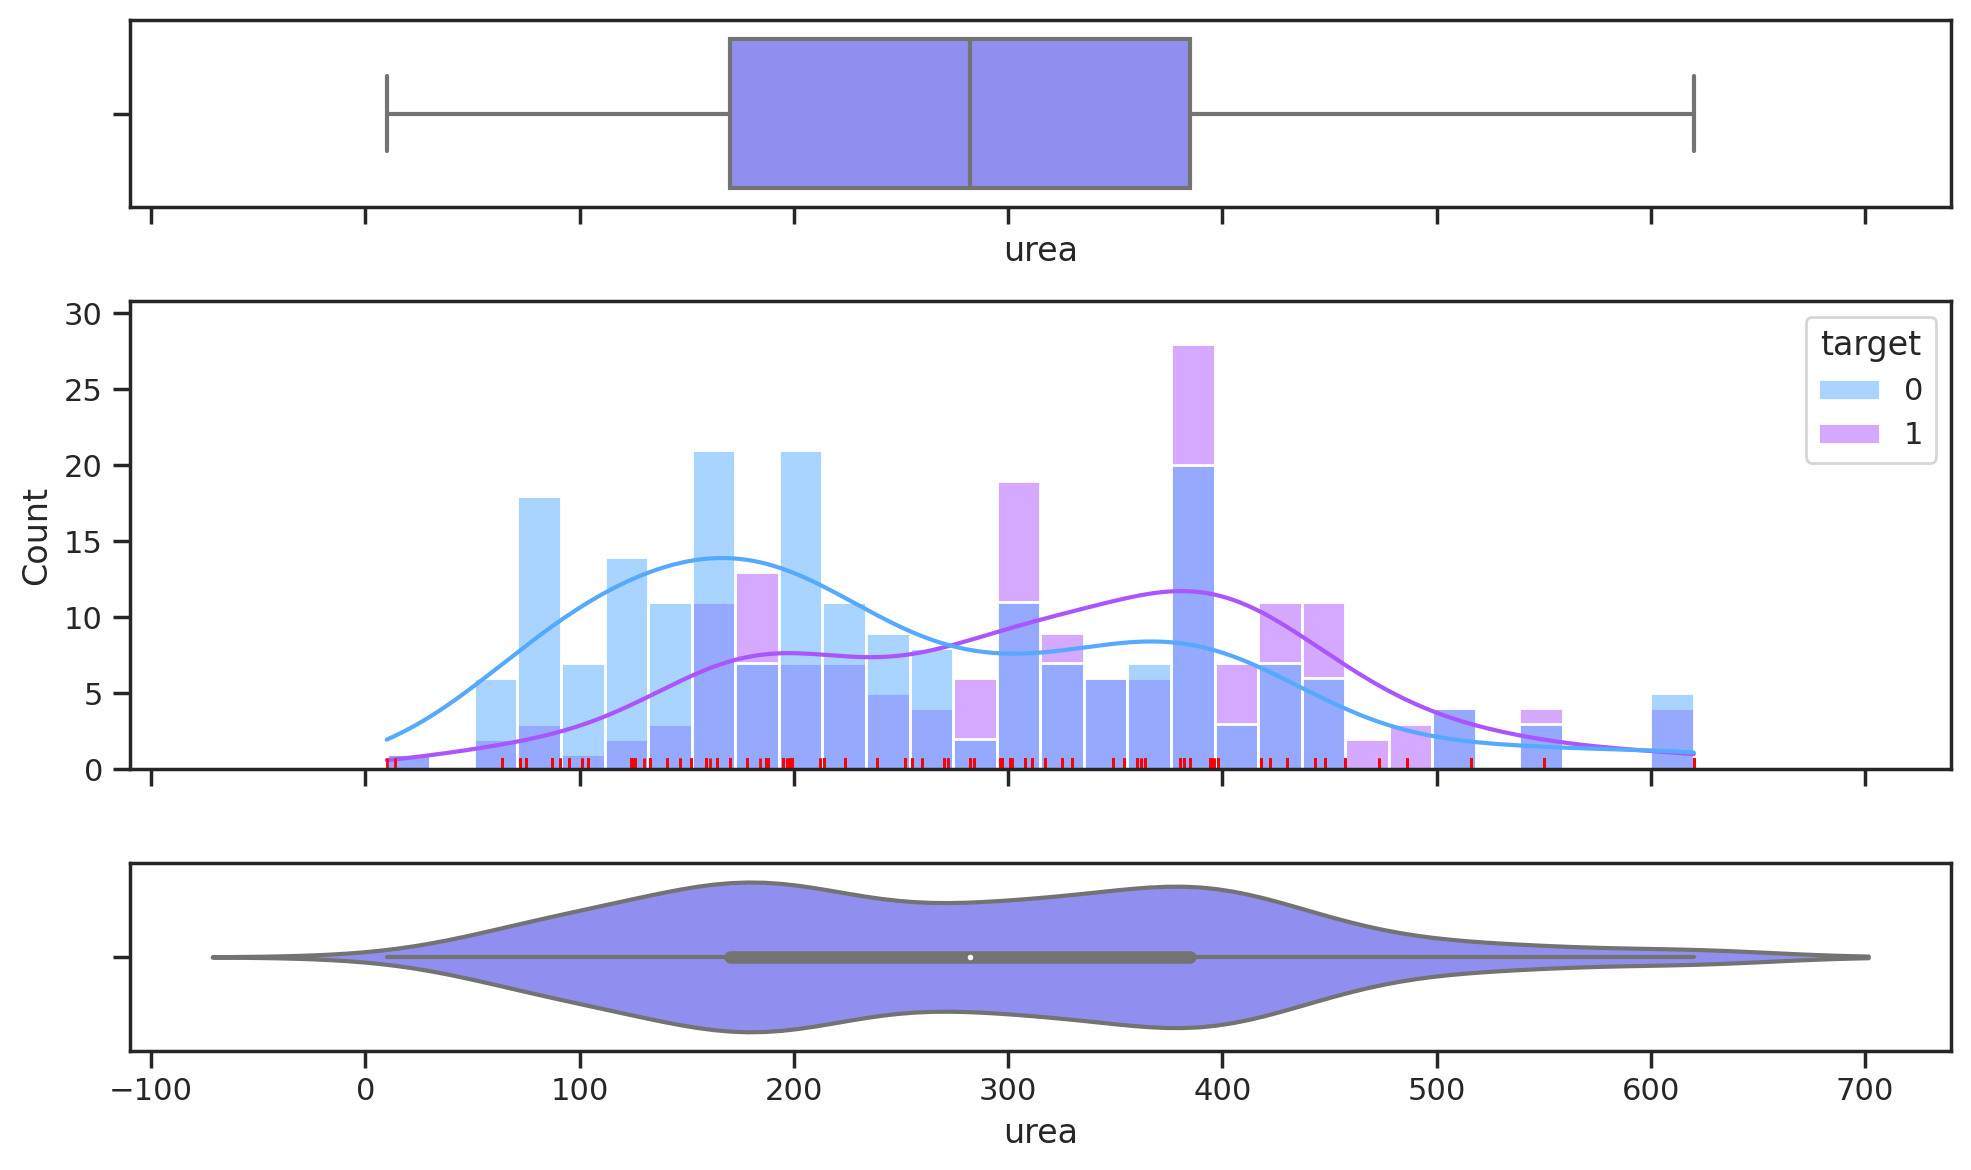

In [25]:
plot_hist_box_violin(df_train, 'urea', 30, 'target')

- We don't see any outliers
- There is no skewness too.

### 2.6 calc

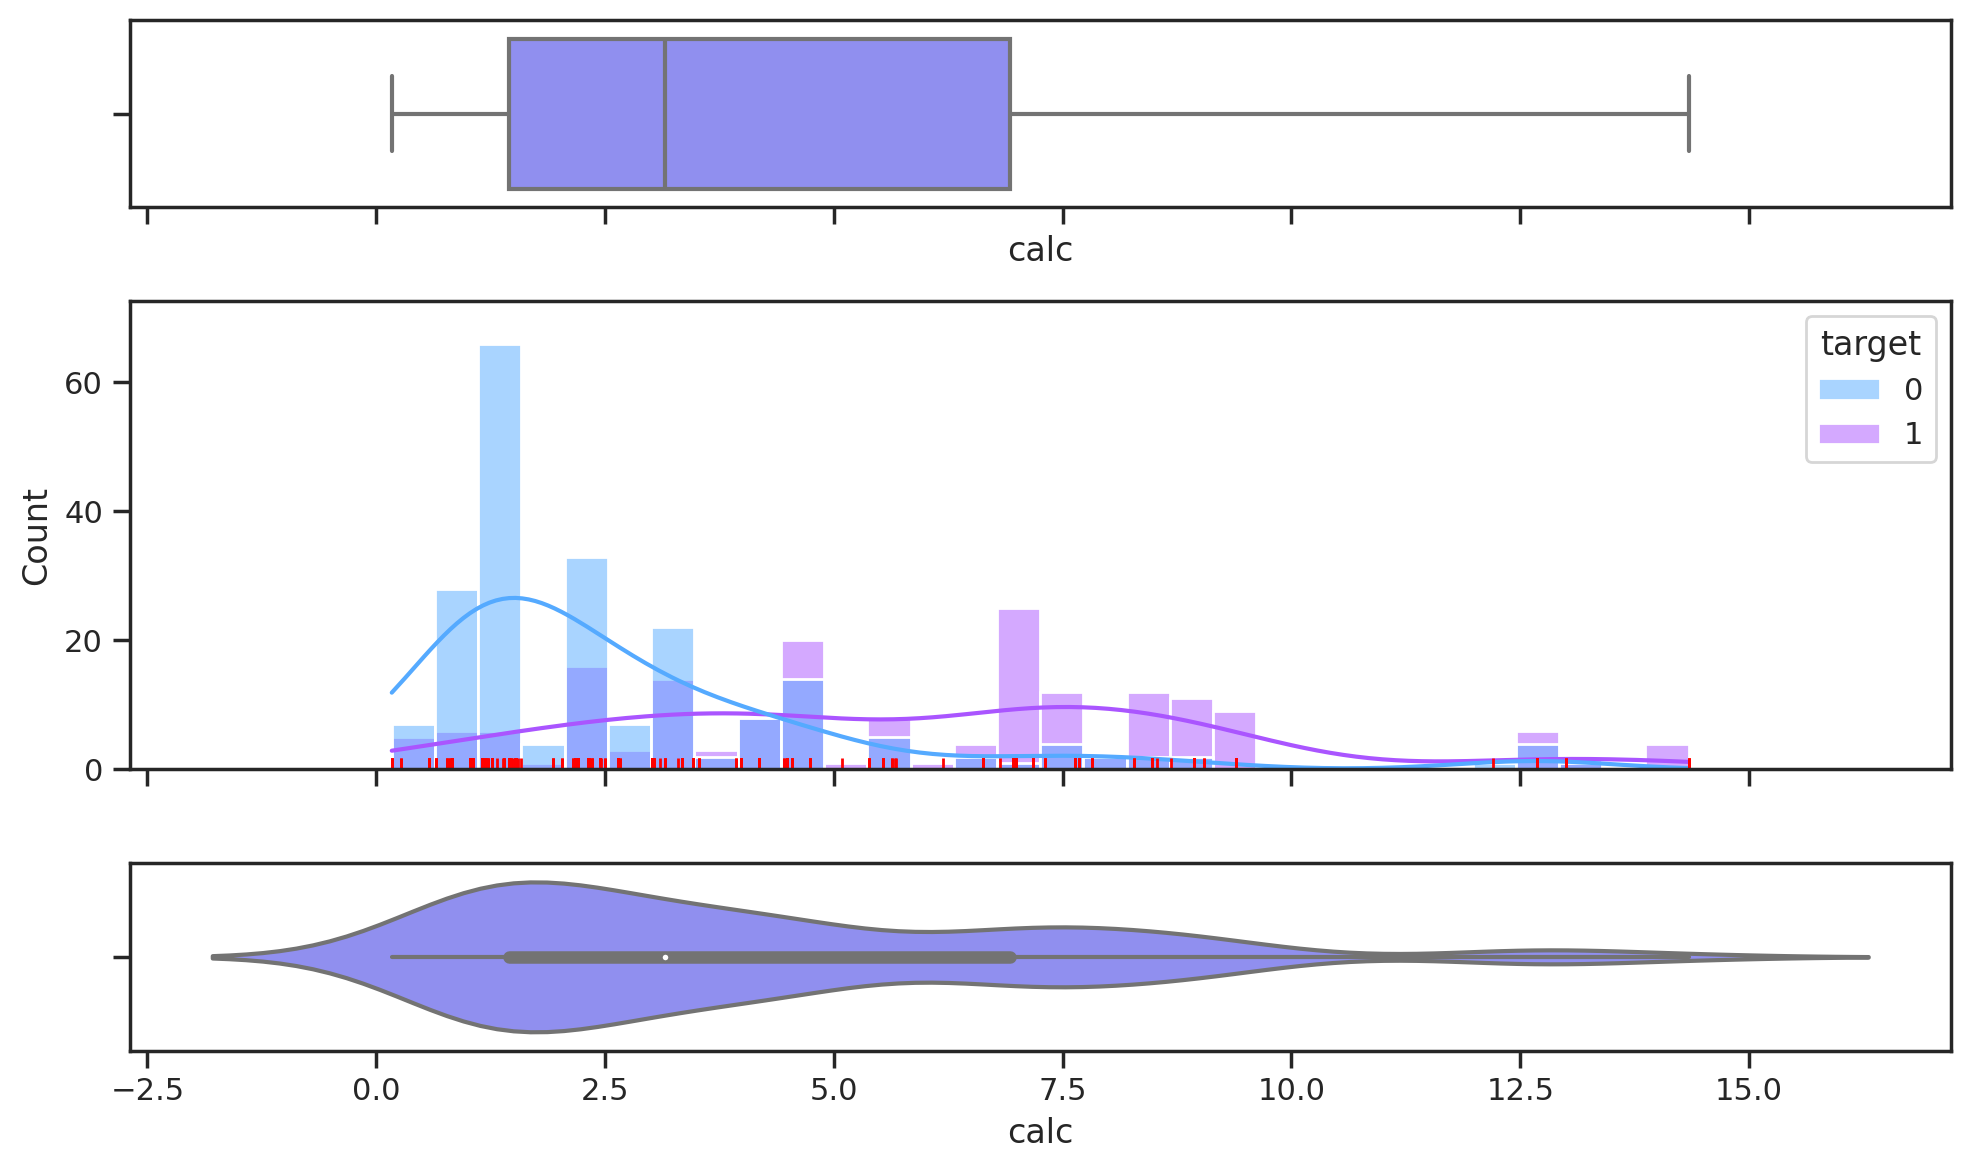

In [26]:
plot_hist_box_violin(df_train, 'calc', 30, 'target')

- We don't see any outliers
- It is highly right skewed.

# 3. Bivariate analysis

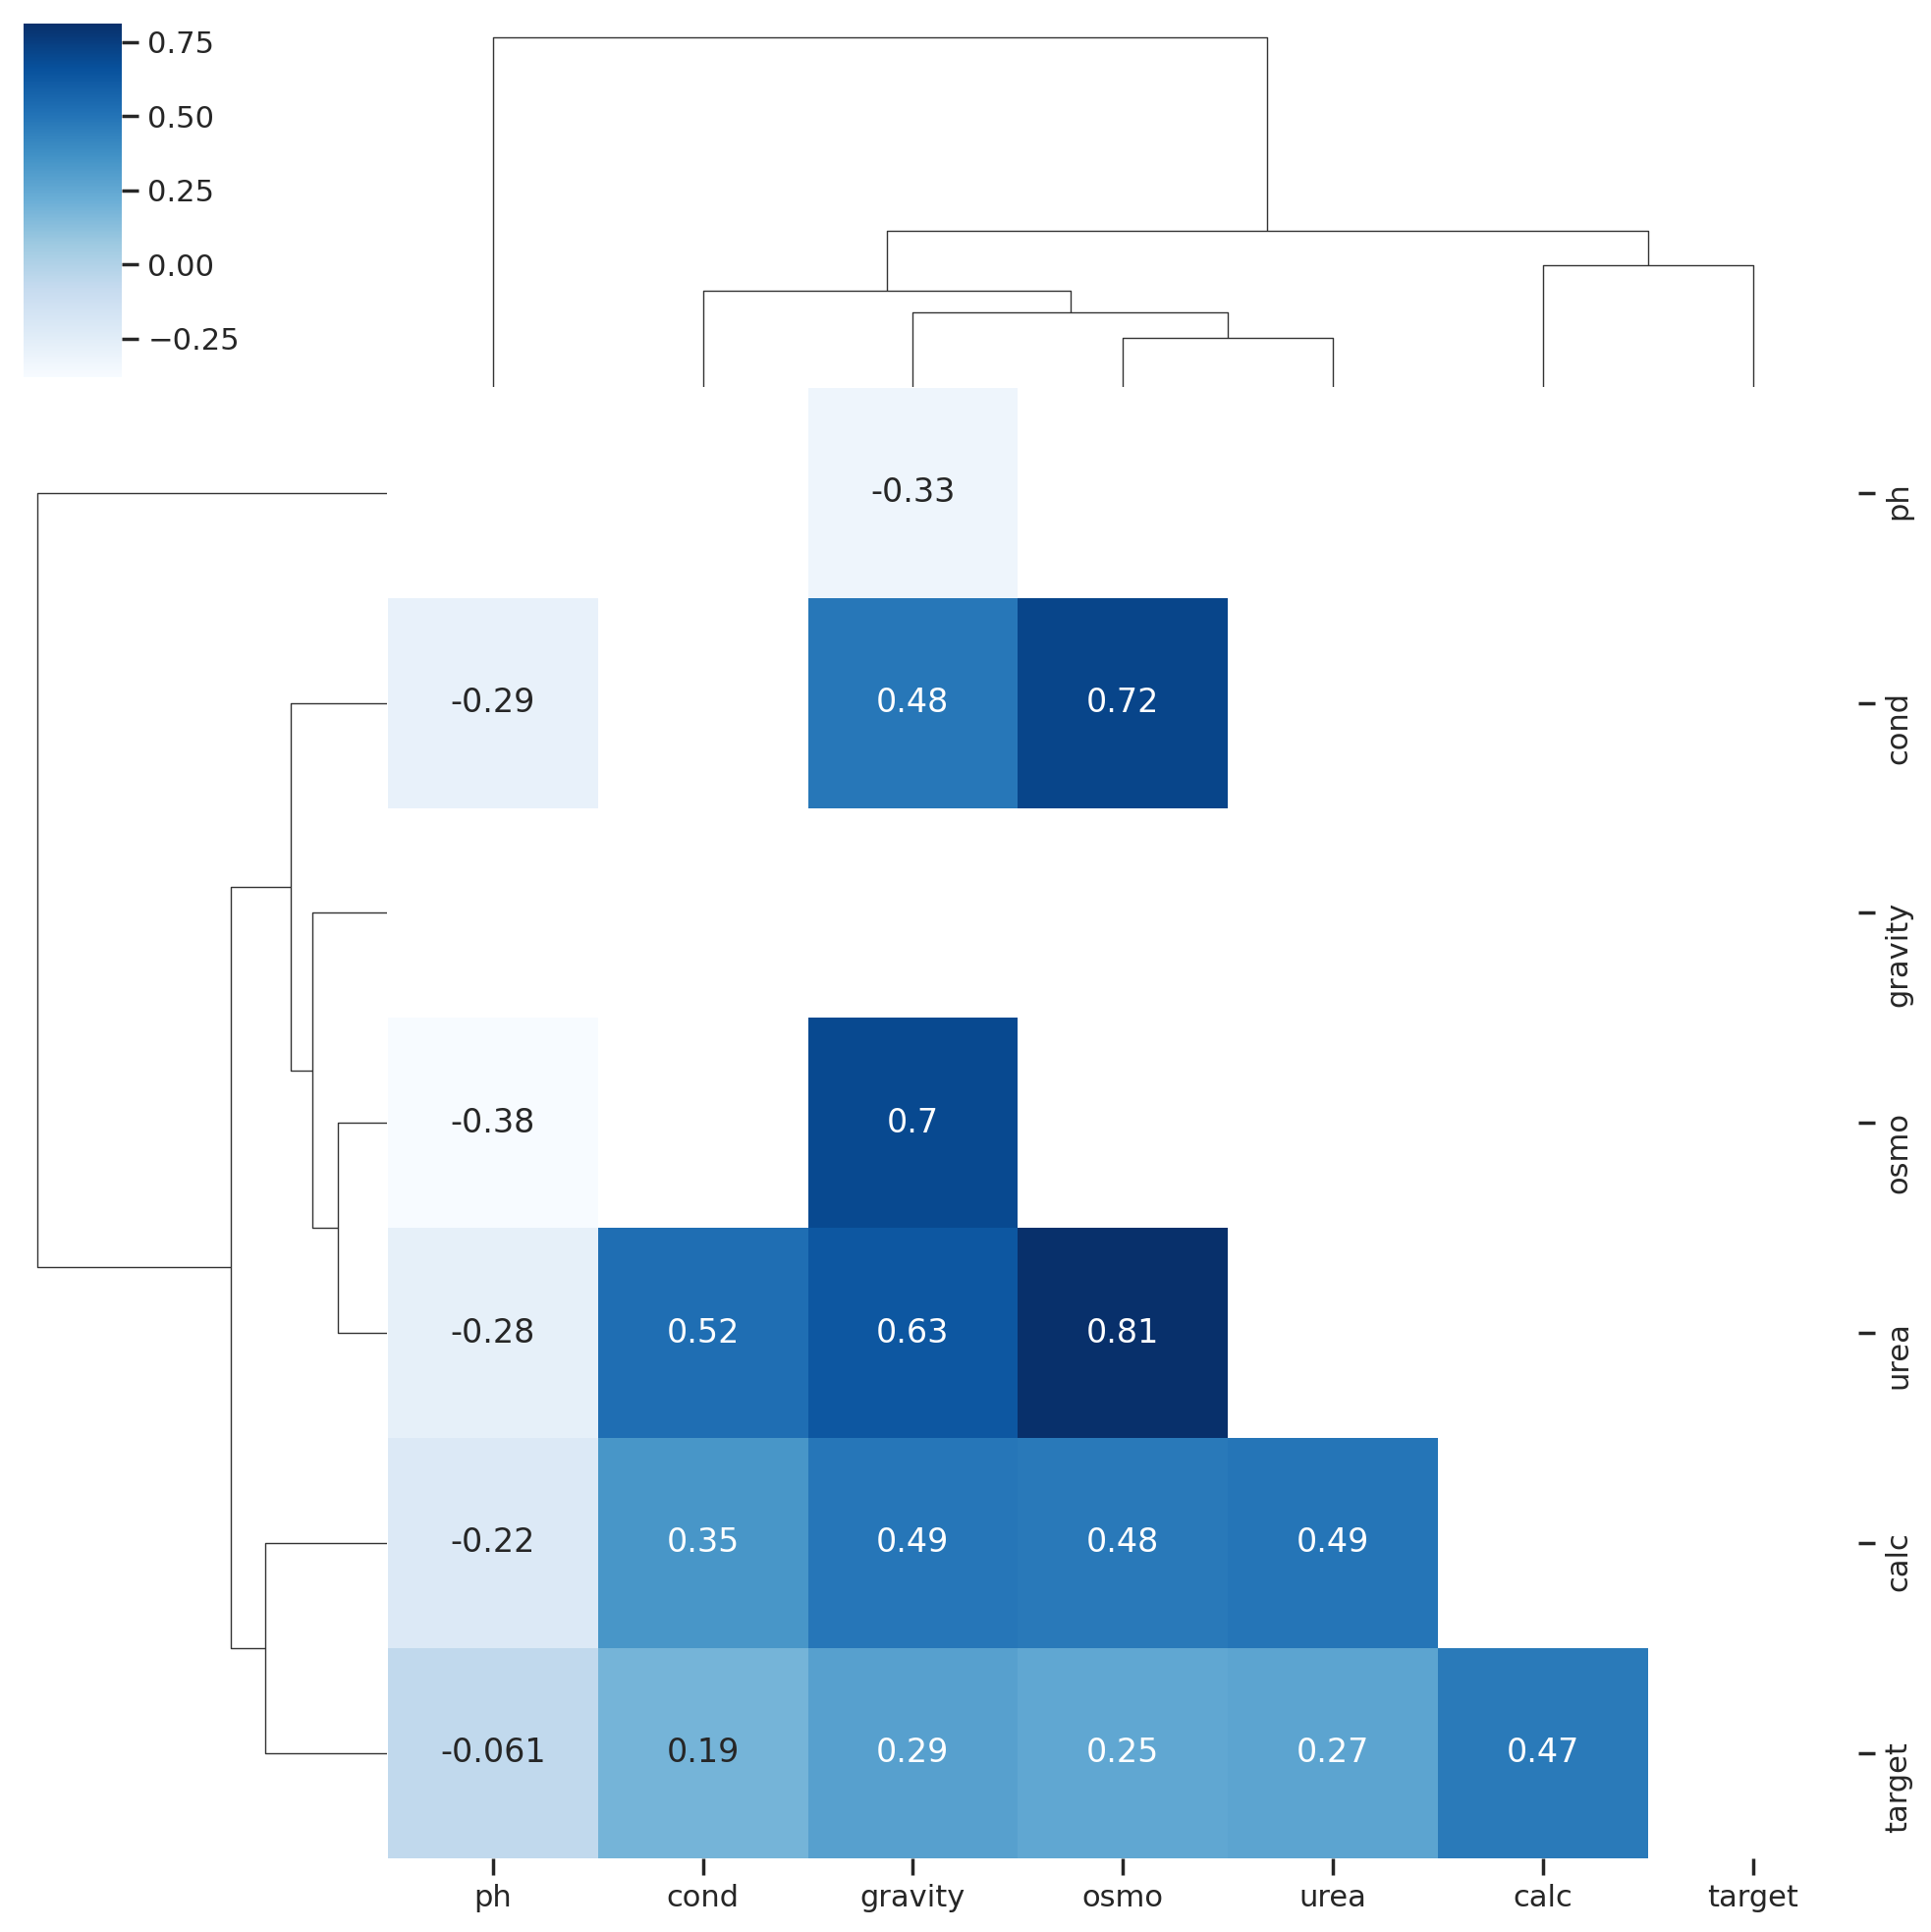

In [27]:
df_train_corr = df_train.corr()
sns.clustermap(df_train_corr, annot = True, mask = np.triu(df_train_corr), cmap="Blues")

In [28]:
# Let's filter >0.4
df_train.corr().style.highlight_between(left=0.4, right=1)

#### Let's see a few pair-wise correlations

In [29]:
def pair_plot(cols):
    sns.pairplot(df_train, x_vars = cols, y_vars = cols, hue = 'target')
    plt.suptitle("Correlation b/w " + cols[0] + " & " + cols[1] + " is " + str(round(df_train[cols[0]].corr(df_train[cols[1]]), 2) * 100) + "%")
    plt.tight_layout()

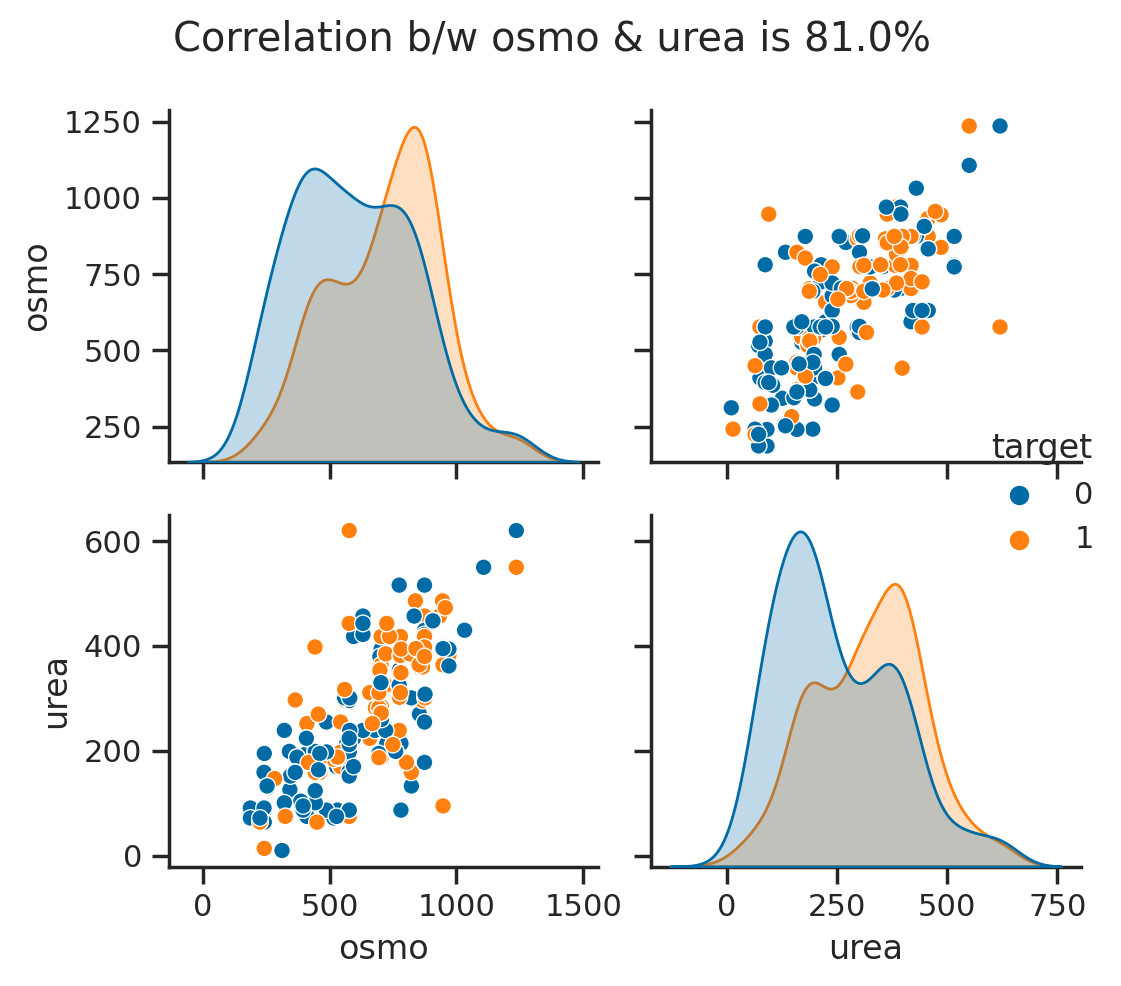

In [30]:
pair_plot(['osmo','urea'])

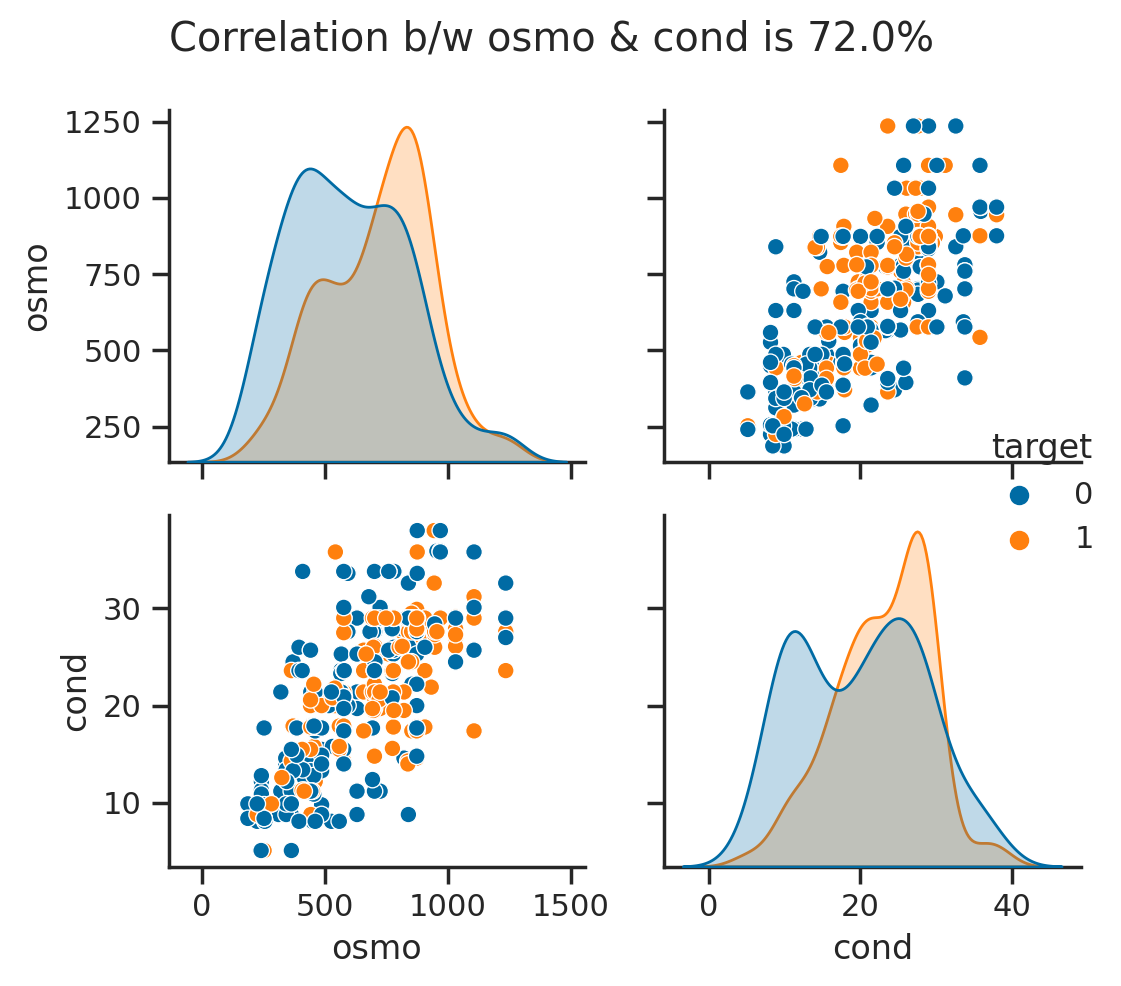

In [31]:
pair_plot(['osmo','cond'])

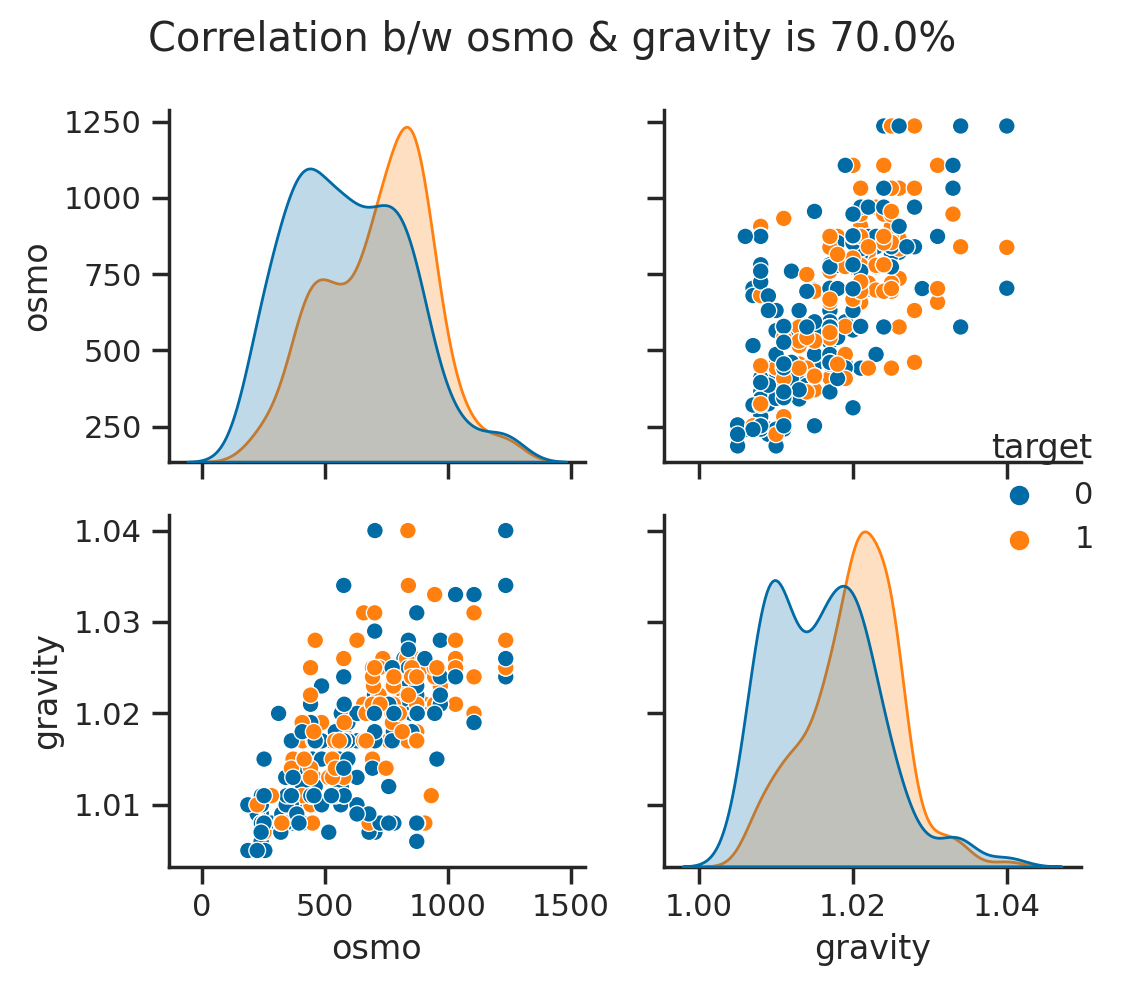

In [32]:
pair_plot(['osmo','gravity'])

#### Pairplot for all the columns

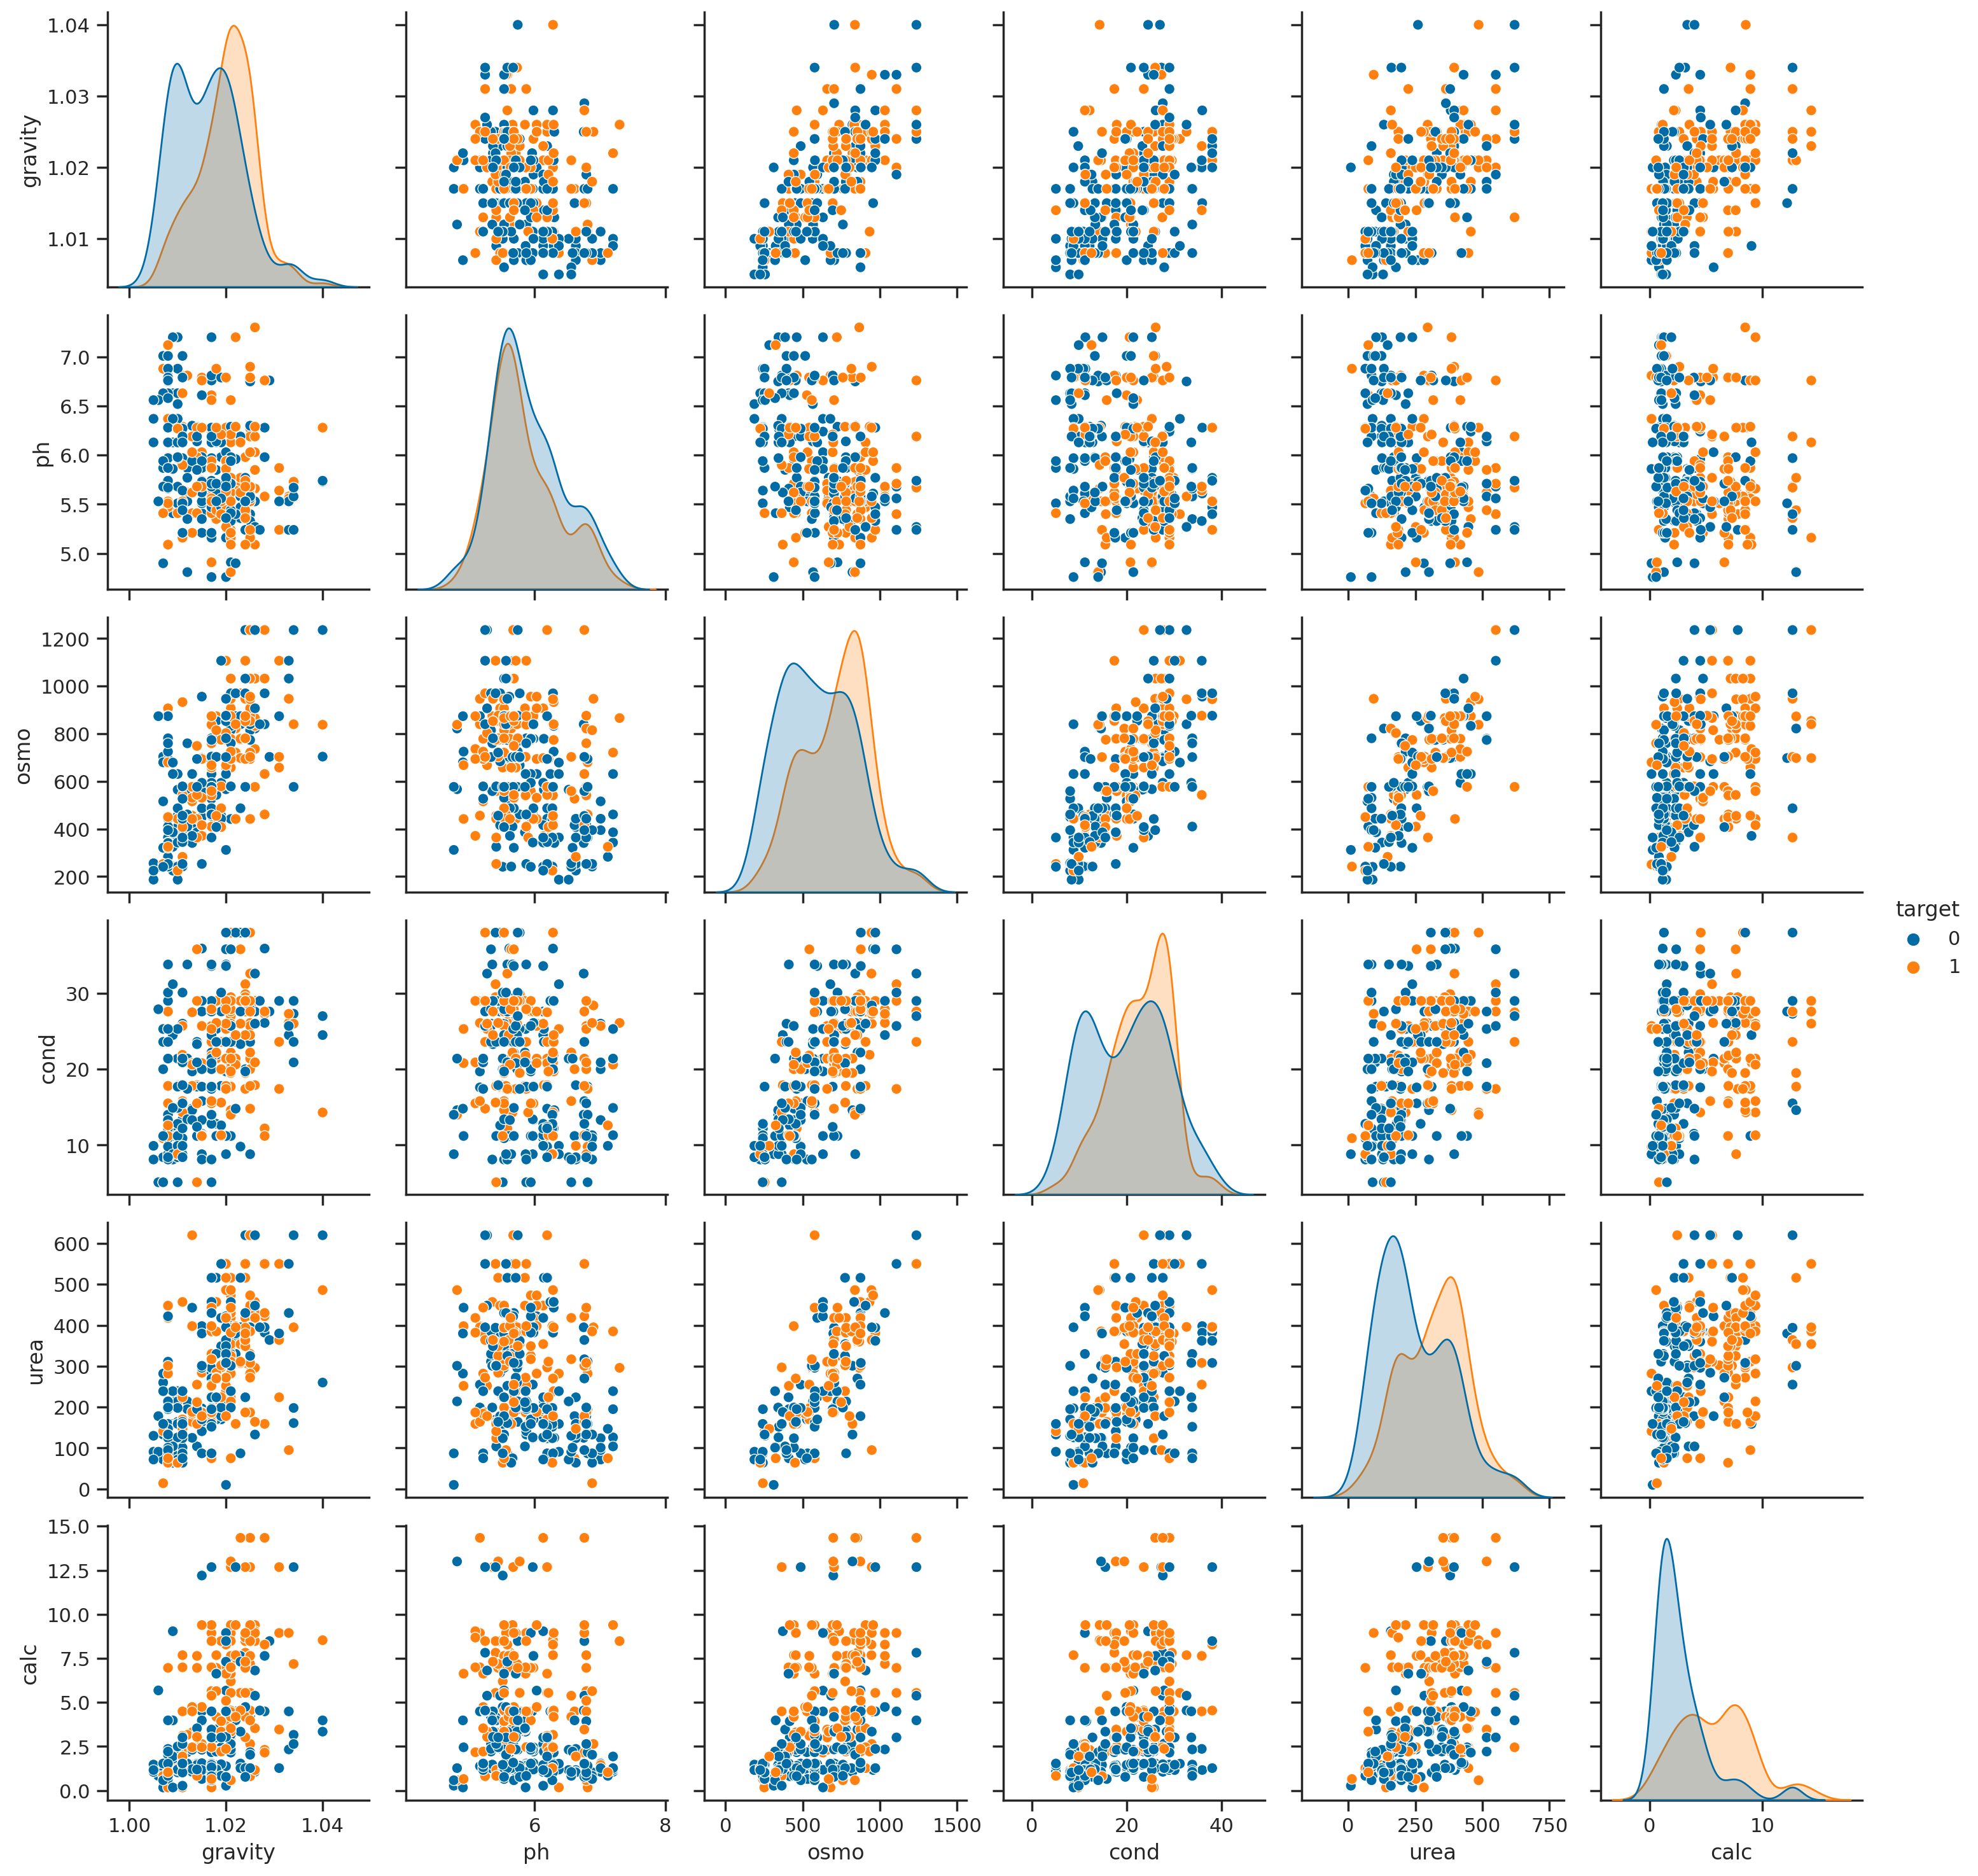

In [33]:
ax = sns.pairplot(df_train, hue='target')

- We see good correlation among the columns. We might drop few columns while modelling (if needed)

# 4. Feature Engineering

- We have to normalize/standardize our data before training the model as it is a prerequisite for few algorithms like kNN, SVM etc

In [34]:
df_train_normalized = df_train.copy()
df_train_normalized

gravity    ph  osmo  cond  urea  calc  target
0      1.013  6.19   443  14.8   124  1.45       0
1      1.025  5.40   703  23.6   394  4.18       0
2      1.009  6.13   371  24.5   159  9.04       0
3      1.021  4.91   442  20.8   398  6.63       1
4      1.021  5.53   874  17.8   385  2.21       1
..       ...   ...   ...   ...   ...   ...     ...
409    1.011  5.21   527  21.4    75  1.53       0
410    1.024  5.53   577  19.7   224  0.77       0
411    1.018  6.28   455  22.2   270  7.68       1
412    1.008  7.12   325  12.6    75  1.03       1
413    1.011  6.13   364   9.9   159  0.27       0

[394 rows x 7 columns]

In [35]:
df_train_standard = df_train.copy()
df_train_standard

gravity    ph  osmo  cond  urea  calc  target
0      1.013  6.19   443  14.8   124  1.45       0
1      1.025  5.40   703  23.6   394  4.18       0
2      1.009  6.13   371  24.5   159  9.04       0
3      1.021  4.91   442  20.8   398  6.63       1
4      1.021  5.53   874  17.8   385  2.21       1
..       ...   ...   ...   ...   ...   ...     ...
409    1.011  5.21   527  21.4    75  1.53       0
410    1.024  5.53   577  19.7   224  0.77       0
411    1.018  6.28   455  22.2   270  7.68       1
412    1.008  7.12   325  12.6    75  1.03       1
413    1.011  6.13   364   9.9   159  0.27       0

[394 rows x 7 columns]

In [36]:
from sklearn.preprocessing import MinMaxScaler

df_train_normalized = MinMaxScaler().fit_transform(df_train_normalized)
df_train_normalized = pd.DataFrame(df_train_normalized)
df_train_normalized

0         1         2         3         4         5    6
0    0.228571  0.562992  0.244042  0.294833  0.186885  0.090332  0.0
1    0.571429  0.251969  0.491897  0.562310  0.629508  0.282992  0.0
2    0.114286  0.539370  0.175405  0.589666  0.244262  0.625970  0.0
3    0.457143  0.059055  0.243089  0.477204  0.636066  0.455893  1.0
4    0.457143  0.303150  0.654909  0.386018  0.614754  0.143966  1.0
..        ...       ...       ...       ...       ...       ...  ...
389  0.171429  0.177165  0.324118  0.495441  0.106557  0.095977  0.0
390  0.542857  0.303150  0.371783  0.443769  0.350820  0.042343  0.0
391  0.371429  0.598425  0.255481  0.519757  0.426230  0.529993  1.0
392  0.085714  0.929134  0.131554  0.227964  0.106557  0.060692  1.0
393  0.171429  0.539370  0.168732  0.145897  0.244262  0.007057  0.0

[394 rows x 7 columns]

In [37]:
df_train

gravity    ph  osmo  cond  urea  calc  target
0      1.013  6.19   443  14.8   124  1.45       0
1      1.025  5.40   703  23.6   394  4.18       0
2      1.009  6.13   371  24.5   159  9.04       0
3      1.021  4.91   442  20.8   398  6.63       1
4      1.021  5.53   874  17.8   385  2.21       1
..       ...   ...   ...   ...   ...   ...     ...
409    1.011  5.21   527  21.4    75  1.53       0
410    1.024  5.53   577  19.7   224  0.77       0
411    1.018  6.28   455  22.2   270  7.68       1
412    1.008  7.12   325  12.6    75  1.03       1
413    1.011  6.13   364   9.9   159  0.27       0

[394 rows x 7 columns]

In [38]:
df_train_normalized.columns = df_train.columns 
df_train_normalized

gravity        ph      osmo      cond      urea      calc  target
0    0.228571  0.562992  0.244042  0.294833  0.186885  0.090332     0.0
1    0.571429  0.251969  0.491897  0.562310  0.629508  0.282992     0.0
2    0.114286  0.539370  0.175405  0.589666  0.244262  0.625970     0.0
3    0.457143  0.059055  0.243089  0.477204  0.636066  0.455893     1.0
4    0.457143  0.303150  0.654909  0.386018  0.614754  0.143966     1.0
..        ...       ...       ...       ...       ...       ...     ...
389  0.171429  0.177165  0.324118  0.495441  0.106557  0.095977     0.0
390  0.542857  0.303150  0.371783  0.443769  0.350820  0.042343     0.0
391  0.371429  0.598425  0.255481  0.519757  0.426230  0.529993     1.0
392  0.085714  0.929134  0.131554  0.227964  0.106557  0.060692     1.0
393  0.171429  0.539370  0.168732  0.145897  0.244262  0.007057     0.0

[394 rows x 7 columns]

In [39]:
from sklearn.preprocessing import StandardScaler

In [40]:
pd.DataFrame(StandardScaler().fit_transform(df_train_standard.iloc[:,:-1]))

0         1         2         3         4         5
0   -0.738964  0.602177 -0.889506 -0.853804 -1.179459 -0.842915
1    1.041781 -0.887874  0.213173  0.298426  0.830358  0.000722
2   -1.332546  0.489008 -1.194863  0.416268 -0.918927  1.502579
3    0.448200 -1.812083 -0.893747 -0.068193  0.860133  0.757831
4    0.448200 -0.642676  0.938397 -0.460998  0.763364 -0.608056
..        ...       ...       ...       ...       ...       ...
389 -1.035755 -1.246241 -0.533256  0.010368 -1.544203 -0.818193
390  0.893386 -0.642676 -0.321202 -0.212221 -0.435082 -1.053051
391  0.003013  0.771929 -0.838613  0.115117 -0.092669  1.082306
392 -1.480942  2.356288 -1.389952 -1.141862 -1.544203 -0.972705
393 -1.035755  0.489008 -1.224551 -1.495387 -0.918927 -1.207563

[394 rows x 6 columns]

In [41]:
df_train_standard['target'].isna().sum()

0

In [42]:
X_normalized, y_normalized = df_train_normalized.iloc[:,:-1], df_train_normalized.iloc[:,-1]
X_normalized
y_normalized

gravity        ph      osmo      cond      urea      calc
0    0.228571  0.562992  0.244042  0.294833  0.186885  0.090332
1    0.571429  0.251969  0.491897  0.562310  0.629508  0.282992
2    0.114286  0.539370  0.175405  0.589666  0.244262  0.625970
3    0.457143  0.059055  0.243089  0.477204  0.636066  0.455893
4    0.457143  0.303150  0.654909  0.386018  0.614754  0.143966
..        ...       ...       ...       ...       ...       ...
389  0.171429  0.177165  0.324118  0.495441  0.106557  0.095977
390  0.542857  0.303150  0.371783  0.443769  0.350820  0.042343
391  0.371429  0.598425  0.255481  0.519757  0.426230  0.529993
392  0.085714  0.929134  0.131554  0.227964  0.106557  0.060692
393  0.171429  0.539370  0.168732  0.145897  0.244262  0.007057

[394 rows x 6 columns]

0      0.0
1      0.0
2      0.0
3      1.0
4      1.0
      ... 
389    0.0
390    0.0
391    1.0
392    1.0
393    0.0
Name: target, Length: 394, dtype: float64

In [43]:
X_normalized.isna().sum()
y_normalized.isna().sum()

gravity    0
ph         0
osmo       0
cond       0
urea       0
calc       0
dtype: int64

0

In [44]:
X_standard, y_standard = pd.DataFrame(StandardScaler().fit_transform(df_train_standard.iloc[:,:-1])), df_train_standard.iloc[:,-1]
X_standard
y_standard

0         1         2         3         4         5
0   -0.738964  0.602177 -0.889506 -0.853804 -1.179459 -0.842915
1    1.041781 -0.887874  0.213173  0.298426  0.830358  0.000722
2   -1.332546  0.489008 -1.194863  0.416268 -0.918927  1.502579
3    0.448200 -1.812083 -0.893747 -0.068193  0.860133  0.757831
4    0.448200 -0.642676  0.938397 -0.460998  0.763364 -0.608056
..        ...       ...       ...       ...       ...       ...
389 -1.035755 -1.246241 -0.533256  0.010368 -1.544203 -0.818193
390  0.893386 -0.642676 -0.321202 -0.212221 -0.435082 -1.053051
391  0.003013  0.771929 -0.838613  0.115117 -0.092669  1.082306
392 -1.480942  2.356288 -1.389952 -1.141862 -1.544203 -0.972705
393 -1.035755  0.489008 -1.224551 -1.495387 -0.918927 -1.207563

[394 rows x 6 columns]

0      0
1      0
2      0
3      1
4      1
      ..
409    0
410    0
411    1
412    1
413    0
Name: target, Length: 394, dtype: int64

# 5. Modelling

In [45]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier

from sklearn.model_selection import train_test_split

In [46]:
X, y = df_train.iloc[:,:-1], df_train.iloc[:,-1]
X
y

gravity    ph  osmo  cond  urea  calc
0      1.013  6.19   443  14.8   124  1.45
1      1.025  5.40   703  23.6   394  4.18
2      1.009  6.13   371  24.5   159  9.04
3      1.021  4.91   442  20.8   398  6.63
4      1.021  5.53   874  17.8   385  2.21
..       ...   ...   ...   ...   ...   ...
409    1.011  5.21   527  21.4    75  1.53
410    1.024  5.53   577  19.7   224  0.77
411    1.018  6.28   455  22.2   270  7.68
412    1.008  7.12   325  12.6    75  1.03
413    1.011  6.13   364   9.9   159  0.27

[394 rows x 6 columns]

0      0
1      0
2      0
3      1
4      1
      ..
409    0
410    0
411    1
412    1
413    0
Name: target, Length: 394, dtype: int64

In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, stratify=y)

clf_tree = DecisionTreeClassifier()
clf_tree.fit(X_train, y_train)
clf_tree.score(X_test, y_test)

clf_knn = KNeighborsClassifier()
clf_knn.fit(X_train, y_train)
clf_knn.score(X_test, y_test)

clf_gnb = GaussianNB()
clf_gnb.fit(X_train, y_train)
clf_gnb.score(X_test, y_test)

clf_svm = SVC()
clf_svm.fit(X_train, y_train)
clf_svm.score(X_test, y_test)

clf_rf = RandomForestClassifier()
clf_rf.fit(X_train, y_train)
clf_rf.score(X_test, y_test)

clf_boost = AdaBoostClassifier()
clf_boost.fit(X_train, y_train)
clf_boost.score(X_test, y_test)

clf_bag = BaggingClassifier()
clf_bag.fit(X_train, y_train)
clf_bag.score(X_test, y_test)

clf_gb = GradientBoostingClassifier()
clf_gb.fit(X_train, y_train)
clf_gb.score(X_test, y_test)

DecisionTreeClassifier()

0.5949367088607594

KNeighborsClassifier()

0.5569620253164557

GaussianNB()

0.7341772151898734

SVC()

0.6582278481012658

RandomForestClassifier()

0.6962025316455697

AdaBoostClassifier()

0.7468354430379747

BaggingClassifier()

0.7088607594936709

GradientBoostingClassifier()

0.6582278481012658

In [48]:
from sklearn.model_selection import cross_val_score 

print("Model performance on various algorithms")
print("---------------------------------------")

clf_tree_cv = cross_val_score(DecisionTreeClassifier(), X, y, cv=5)
print("Decision tree",round(np.mean(clf_tree_cv), 4) * 100,"%")
print()

clf_knn_cv = cross_val_score(KNeighborsClassifier(), X, y, cv=5)
print("kNN",round(np.mean(clf_knn_cv), 4) * 100,"%")
print()

clf_gnb_cv = cross_val_score(GaussianNB(), X, y, cv=5)
print("GNB",round(np.mean(clf_gnb_cv), 4) * 100,"%")
print()

clf_svm_cv = cross_val_score(SVC(), X, y, cv=5)
print("SVM",round(np.mean(clf_svm_cv), 4) * 100,"%")
print()

clf_rf_cv = cross_val_score(RandomForestClassifier() , X, y, cv=5)
print("Random forests",round(np.mean(clf_rf_cv), 4) * 100,"%")
print()

clf_bag_cv = cross_val_score(BaggingClassifier() , X, y, cv=5)
print("Bagging",round(np.mean(clf_bag_cv), 4) * 100,"%")
print()

clf_boost_cv = cross_val_score(AdaBoostClassifier() , X, y, cv=5)
print("Ada boost",round(np.mean(clf_boost_cv), 4) * 100,"%")
print()

clf_grad_boost_cv = cross_val_score(GradientBoostingClassifier() , X, y, cv=5)
print("Gradient boosting",round(np.mean(clf_grad_boost_cv), 4) * 100,"%")
print()

Model performance on various algorithms
---------------------------------------
Decision tree 64.45 %

kNN 59.89 %

GNB 67.5 %

SVM 62.419999999999995 %

Random forests 70.28999999999999 %

Bagging 69.04 %

Ada boost 68.78 %

Gradient boosting 68.52000000000001 %



In [49]:
scores = pd.DataFrame({
                        "Plain - CV": [
                                  round(np.mean(clf_tree_cv), 4) * 100,
                                  round(np.mean(clf_knn_cv), 4) * 100,
                                  round(np.mean(clf_gnb_cv), 4) * 100,
                                  round(np.mean(clf_svm_cv), 4) * 100,
                                  round(np.mean(clf_rf_cv), 4) * 100,
                                  round(np.mean(clf_bag_cv), 4) * 100,
                                  round(np.mean(clf_boost_cv), 4) * 100,
                                  round(np.mean(clf_grad_boost_cv), 4) * 100
                                 ],
                        "Plain - train-test-split": [
                              round(clf_tree.score(X_test, y_test), 4) * 100,
                              round(clf_knn.score(X_test, y_test), 4) * 100,
                              round(clf_gnb.score(X_test, y_test), 4) * 100,
                              round(clf_svm.score(X_test, y_test), 4) * 100,
                              round(clf_rf.score(X_test, y_test), 4) * 100,
                              round(clf_bag.score(X_test, y_test), 4) * 100,
                              round(clf_boost.score(X_test, y_test), 4) * 100,
                              round(clf_gb.score(X_test, y_test), 4) * 100,
                             ]
                        },
                        index = ["Decision Tree", "kNN", "GNB", "SVM" , "Random forests", "Bagging", "Ada Boost", "Gradient Boosting"] )
scores

Plain - CV  Plain - train-test-split
Decision Tree           64.45                     59.49
kNN                     59.89                     55.70
GNB                     67.50                     73.42
SVM                     62.42                     65.82
Random forests          70.29                     69.62
Bagging                 69.04                     70.89
Ada Boost               68.78                     74.68
Gradient Boosting       68.52                     65.82

#### Normalization

In [50]:
X_train_normalized, X_test_normalized, y_train_normalized, y_test_normalized = train_test_split(
    X_normalized, y_normalized, train_size=0.8, stratify=y_normalized)

clf_tree_normalized = DecisionTreeClassifier()
clf_tree_normalized.fit(X_train_normalized, y_train_normalized)
clf_tree_normalized.score(X_test_normalized, y_test_normalized)

clf_knn_normalized = KNeighborsClassifier()
clf_knn_normalized.fit(X_train_normalized, y_train_normalized)
clf_knn_normalized.score(X_test_normalized, y_test_normalized)

clf_gnb_normalized = GaussianNB()
clf_gnb_normalized.fit(X_train_normalized, y_train_normalized)
clf_gnb_normalized.score(X_test_normalized, y_test_normalized)

clf_svm_normalized = SVC()
clf_svm_normalized.fit(X_train_normalized, y_train_normalized)
clf_svm_normalized.score(X_test_normalized, y_test_normalized)

clf_rf_normalized = RandomForestClassifier()
clf_rf_normalized.fit(X_train_normalized, y_train_normalized)
clf_rf_normalized.score(X_test_normalized, y_test_normalized)

clf_boost_normalized = AdaBoostClassifier()
clf_boost_normalized.fit(X_train_normalized, y_train_normalized)
clf_boost_normalized.score(X_test_normalized, y_test_normalized)

clf_bag_normalized = BaggingClassifier()
clf_bag_normalized.fit(X_train_normalized, y_train_normalized)
clf_bag_normalized.score(X_test_normalized, y_test_normalized)

clf_gb_normalized = GradientBoostingClassifier()
clf_gb_normalized.fit(X_train_normalized, y_train_normalized)
clf_gb_normalized.score(X_test_normalized, y_test_normalized)

DecisionTreeClassifier()

0.6582278481012658

KNeighborsClassifier()

0.7341772151898734

GaussianNB()

0.7215189873417721

SVC()

0.8227848101265823

RandomForestClassifier()

0.7468354430379747

AdaBoostClassifier()

0.7088607594936709

BaggingClassifier()

0.7468354430379747

GradientBoostingClassifier()

0.7341772151898734

In [51]:
from sklearn.model_selection import cross_val_score 

print("Model performance on various algorithms")
print("---------------------------------------")

clf_tree_cv_normalized = cross_val_score(DecisionTreeClassifier(), X_normalized, y_normalized, cv=5)
print("Decision tree",round(np.mean(clf_tree_cv_normalized), 4) * 100,"%")
print()

clf_knn_cv_normalized = cross_val_score(KNeighborsClassifier(), X_normalized, y_normalized, cv=5)
print("kNN",round(np.mean(clf_knn_cv_normalized), 4) * 100,"%")
print()

clf_gnb_cv_normalized = cross_val_score(GaussianNB(), X_normalized, y_normalized, cv=5)
print("GNB",round(np.mean(clf_gnb_cv_normalized), 4) * 100,"%")
print()

clf_svm_cv_normalized = cross_val_score(SVC(), X_normalized, y_normalized, cv=5)
print("SVM",round(np.mean(clf_svm_cv_normalized), 4) * 100,"%")
print()

clf_rf_cv_normalized = cross_val_score(RandomForestClassifier() , X_normalized, y_normalized, cv=5)
print("Random forests",round(np.mean(clf_rf_cv_normalized), 4) * 100,"%")
print()

clf_bag_cv_normalized = cross_val_score(BaggingClassifier() , X_normalized, y_normalized, cv=5)
print("Bagging",round(np.mean(clf_bag_cv_normalized), 4) * 100,"%")
print()

clf_boost_cv_normalized = cross_val_score(AdaBoostClassifier() , X_normalized, y_normalized, cv=5)
print("Ada boost",round(np.mean(clf_boost_cv_normalized), 4) * 100,"%")
print()

clf_grad_boost_cv_normalized = cross_val_score(GradientBoostingClassifier() , X_normalized, y_normalized, cv=5)
print("Gradient boosting",round(np.mean(clf_grad_boost_cv_normalized), 4) * 100,"%")
print()

Model performance on various algorithms
---------------------------------------
Decision tree 64.71000000000001 %

kNN 71.05 %

GNB 66.49000000000001 %

SVM 73.09 %

Random forests 69.78999999999999 %

Bagging 72.84 %

Ada boost 68.78 %

Gradient boosting 68.27 %



In [52]:
scores_normalized = pd.DataFrame({
                        "Normalized - CV": [
                                  round(np.mean(clf_tree_cv_normalized), 4) * 100,
                                  round(np.mean(clf_knn_cv_normalized), 4) * 100,
                                  round(np.mean(clf_gnb_cv_normalized), 4) * 100,
                                  round(np.mean(clf_svm_cv_normalized), 4) * 100,
                                  round(np.mean(clf_rf_cv_normalized), 4) * 100,
                                  round(np.mean(clf_bag_cv_normalized), 4) * 100,
                                  round(np.mean(clf_boost_cv_normalized), 4) * 100,
                                  round(np.mean(clf_grad_boost_cv_normalized), 4) * 100
                                 ],
                        "Normalized - train-test-split": [
                              round(clf_tree_normalized.score(X_test_normalized, y_test_normalized), 4) * 100,
                              round(clf_knn_normalized.score(X_test_normalized, y_test_normalized), 4) * 100,
                              round(clf_gnb_normalized.score(X_test_normalized, y_test_normalized), 4) * 100,
                              round(clf_svm_normalized.score(X_test_normalized, y_test_normalized), 4) * 100,
                              round(clf_rf_normalized.score(X_test_normalized, y_test_normalized), 4) * 100,
                              round(clf_bag_normalized.score(X_test_normalized, y_test_normalized), 4) * 100,
                              round(clf_boost_normalized.score(X_test_normalized, y_test_normalized), 4) * 100,
                              round(clf_gb_normalized.score(X_test_normalized, y_test_normalized), 4) * 100,
                             ]
                        },
                        index = ["Decision Tree", "kNN", "GNB", "SVM" , "Random forests", "Bagging", "Ada Boost", "Gradient Boosting"] )
scores_normalized

Normalized - CV  Normalized - train-test-split
Decision Tree                64.71                          65.82
kNN                          71.05                          73.42
GNB                          66.49                          72.15
SVM                          73.09                          82.28
Random forests               69.79                          74.68
Bagging                      72.84                          74.68
Ada Boost                    68.78                          70.89
Gradient Boosting            68.27                          73.42

#### Standardization

In [53]:
X_train_standard, X_test_standard, y_train_standard, y_test_standard = train_test_split(
    X_standard, y_standard, train_size=0.8, stratify=y_standard)

clf_tree_standard = DecisionTreeClassifier()
clf_tree_standard.fit(X_train_standard, y_train_standard)
clf_tree_standard.score(X_test_standard, y_test_standard)

clf_knn_standard = KNeighborsClassifier()
clf_knn_standard.fit(X_train_standard, y_train_standard)
clf_knn_standard.score(X_test_standard, y_test_standard)

clf_gnb_standard = GaussianNB()
clf_gnb_standard.fit(X_train_standard, y_train_standard)
clf_gnb_standard.score(X_test_standard, y_test_standard)

clf_svm_standard = SVC()
clf_svm_standard.fit(X_train_standard, y_train_standard)
clf_svm_standard.score(X_test_standard, y_test_standard)

clf_rf_standard = RandomForestClassifier()
clf_rf_standard.fit(X_train_standard, y_train_standard)
clf_rf_standard.score(X_test_standard, y_test_standard)

clf_boost_standard = AdaBoostClassifier()
clf_boost_standard.fit(X_train_standard, y_train_standard)
clf_boost_standard.score(X_test_standard, y_test_standard)

clf_bag_standard = BaggingClassifier()
clf_bag_standard.fit(X_train_standard, y_train_standard)
clf_bag_standard.score(X_test_standard, y_test_standard)

clf_gb_standard = GradientBoostingClassifier()
clf_gb_standard.fit(X_train_standard, y_train_standard)
clf_gb_standard.score(X_test_standard, y_test_standard)

DecisionTreeClassifier()

0.6708860759493671

KNeighborsClassifier()

0.7974683544303798

GaussianNB()

0.7721518987341772

SVC()

0.759493670886076

RandomForestClassifier()

0.759493670886076

AdaBoostClassifier()

0.7341772151898734

BaggingClassifier()

0.6962025316455697

GradientBoostingClassifier()

0.7088607594936709

In [54]:
from sklearn.model_selection import cross_val_score 

print("Model performance on various algorithms")
print("---------------------------------------")

clf_tree_cv_standard = cross_val_score(DecisionTreeClassifier(), X_standard, y_standard, cv=5)
print("Decision tree",round(np.mean(clf_tree_cv_standard), 4) * 100,"%")
print()

clf_knn_cv_standard = cross_val_score(KNeighborsClassifier(), X_standard, y_standard, cv=5)
print("kNN",round(np.mean(clf_knn_cv_standard), 4) * 100,"%")
print()

clf_gnb_cv_standard = cross_val_score(GaussianNB(), X_standard, y_standard, cv=5)
print("GNB",round(np.mean(clf_gnb_cv_standard), 4) * 100,"%")
print()

clf_svm_cv_standard = cross_val_score(SVC(), X_standard, y_standard, cv=5)
print("SVM",round(np.mean(clf_svm_cv_standard), 4) * 100,"%")
print()

clf_rf_cv_standard = cross_val_score(RandomForestClassifier() , X_standard, y_standard, cv=5)
print("Random forests",round(np.mean(clf_rf_cv_standard), 4) * 100,"%")
print()

clf_bag_cv_standard = cross_val_score(BaggingClassifier() , X_standard, y_standard, cv=5)
print("Bagging",round(np.mean(clf_bag_cv_standard), 4) * 100,"%")
print()

clf_boost_cv_standard = cross_val_score(AdaBoostClassifier() , X_standard, y_standard, cv=5)
print("Ada boost",round(np.mean(clf_boost_cv_standard), 4) * 100,"%")
print()

clf_grad_boost_cv_standard = cross_val_score(GradientBoostingClassifier() , X_standard, y_standard, cv=5)
print("Gradient boosting",round(np.mean(clf_grad_boost_cv_standard), 4) * 100,"%")
print()

Model performance on various algorithms
---------------------------------------
Decision tree 63.959999999999994 %

kNN 70.28999999999999 %

GNB 66.49000000000001 %

SVM 72.84 %

Random forests 70.8 %

Bagging 69.8 %

Ada boost 68.78 %

Gradient boosting 68.52000000000001 %



In [55]:
scores_standard = pd.DataFrame({
                        "Standardized - CV": [
                                  round(np.mean(clf_tree_cv_standard), 4) * 100,
                                  round(np.mean(clf_knn_cv_standard), 4) * 100,
                                  round(np.mean(clf_gnb_cv_standard), 4) * 100,
                                  round(np.mean(clf_svm_cv_standard), 4) * 100,
                                  round(np.mean(clf_rf_cv_standard), 4) * 100,
                                  round(np.mean(clf_bag_cv_standard), 4) * 100,
                                  round(np.mean(clf_boost_cv_standard), 4) * 100,
                                  round(np.mean(clf_grad_boost_cv_standard), 4) * 100
                                 ],
                        "Standardized - train-test-split": [
                              round(clf_tree_standard.score(X_test_standard, y_test_standard), 4) * 100,
                              round(clf_knn_standard.score(X_test_standard, y_test_standard), 4) * 100,
                              round(clf_gnb_standard.score(X_test_standard, y_test_standard), 4) * 100,
                              round(clf_svm_standard.score(X_test_standard, y_test_standard), 4) * 100,
                              round(clf_rf_standard.score(X_test_standard, y_test_standard), 4) * 100,
                              round(clf_bag_standard.score(X_test_standard, y_test_standard), 4) * 100,
                              round(clf_boost_standard.score(X_test_standard, y_test_standard), 4) * 100,
                              round(clf_gb_standard.score(X_test_standard, y_test_standard), 4) * 100,
                             ]
                        },
                        index = ["Decision Tree", "kNN", "GNB", "SVM" , "Random forests", "Bagging", "Ada Boost", "Gradient Boosting"] )
scores_standard

Standardized - CV  Standardized - train-test-split
Decision Tree                  63.96                            67.09
kNN                            70.29                            79.75
GNB                            66.49                            77.22
SVM                            72.84                            75.95
Random forests                 70.80                            75.95
Bagging                        69.80                            69.62
Ada Boost                      68.78                            73.42
Gradient Boosting              68.52                            70.89

In [56]:
def train_models(X_train, X_test, y_train, y_test):

    scores = dict()
    
    clf_tree = DecisionTreeClassifier()
    clf_tree.fit(X_train, y_train)
    scores["Tree"] = clf_tree.score(X_test, y_test)

    clf_knn = KNeighborsClassifier()
    clf_knn.fit(X_train, y_train)
    scores["kNN"] = clf_knn.score(X_test, y_test)

    clf_gnb = GaussianNB()
    clf_gnb.fit(X_train, y_train)
    scores["GNB"] = clf_gnb.score(X_test, y_test)

    clf_svm = SVC()
    clf_svm.fit(X_train, y_train)
    scores["SVM"] = clf_svm.score(X_test, y_test)

    clf_rf = RandomForestClassifier()
    clf_rf.fit(X_train, y_train)
    scores["Random Forests"] = clf_rf.score(X_test, y_test)

    clf_boost = AdaBoostClassifier()
    clf_boost.fit(X_train, y_train)
    scores["AdaBoost"] = clf_boost.score(X_test, y_test)

    clf_bag = BaggingClassifier()
    clf_bag.fit(X_train, y_train)
    scores["Bagging"] = clf_bag.score(X_test, y_test)

    clf_gb = GradientBoostingClassifier()
    clf_gb.fit(X_train, y_train)
    scores["Gradient boost"] = clf_gb.score(X_test, y_test)
    
    return scores

In [57]:
def train_models_cv(X_, y_, cv):

    scores = dict()
    
    clf_tree_cv_ = cross_val_score(DecisionTreeClassifier(), X_, y_, cv=cv)
    scores["Decision tree"] = round(np.mean(clf_tree_cv_), 4) * 100

    clf_knn_cv_ = cross_val_score(KNeighborsClassifier(), X_, y_, cv=cv)
    scores["kNN"] = round(np.mean(clf_knn_cv_), 4) * 100

    clf_gnb_cv_ = cross_val_score(GaussianNB(), X_, y_, cv=cv)
    scores["GNB"] = round(np.mean(clf_gnb_cv_), 4) * 100

    clf_svm_cv_ = cross_val_score(SVC(), X_, y_, cv=cv)
    scores["SVM"] = round(np.mean(clf_svm_cv_), 4) * 100
    print()

    clf_rf_cv_ = cross_val_score(RandomForestClassifier() , X_, y_, cv=cv)
    scores["Random forests"] = round(np.mean(clf_rf_cv_), 4) * 100

    clf_bag_cv_ = cross_val_score(BaggingClassifier() , X_, y_, cv=cv)
    scores["Bagging"] = round(np.mean(clf_bag_cv_), 4) * 100

    clf_boost_cv_ = cross_val_score(AdaBoostClassifier() , X_, y_, cv=cv)
    scores["Ada boost"] = round(np.mean(clf_boost_cv_), 4) * 100

    clf_grad_boost_cv_ = cross_val_score(GradientBoostingClassifier() , X_, y_, cv=cv)
    scores["Gradient boosting"] = round(np.mean(clf_grad_boost_cv_), 4) * 100
    
    return scores

In [58]:
train_models(X_train, X_test, y_train, y_test)

{'Tree': 0.5569620253164557,
 'kNN': 0.5569620253164557,
 'GNB': 0.7341772151898734,
 'SVM': 0.6582278481012658,
 'Random Forests': 0.6708860759493671,
 'AdaBoost': 0.7468354430379747,
 'Bagging': 0.6455696202531646,
 'Gradient boost': 0.6455696202531646}

In [59]:
scores 

Plain - CV  Plain - train-test-split
Decision Tree           64.45                     59.49
kNN                     59.89                     55.70
GNB                     67.50                     73.42
SVM                     62.42                     65.82
Random forests          70.29                     69.62
Bagging                 69.04                     70.89
Ada Boost               68.78                     74.68
Gradient Boosting       68.52                     65.82

In [60]:
train_models_cv(df_train.iloc[:,:-1], df_train.iloc[:,-1],  5)

{'Decision tree': 65.48,
 'kNN': 59.89,
 'GNB': 67.5,
 'SVM': 62.419999999999995,
 'Random forests': 71.05,
 'Bagging': 67.77,
 'Ada boost': 68.78,
 'Gradient boosting': 68.52000000000001}

In [61]:
train_models(X_train_normalized, X_test_normalized, y_train_normalized, y_test_normalized)

{'Tree': 0.620253164556962,
 'kNN': 0.7341772151898734,
 'GNB': 0.7215189873417721,
 'SVM': 0.8227848101265823,
 'Random Forests': 0.7721518987341772,
 'AdaBoost': 0.7088607594936709,
 'Bagging': 0.7088607594936709,
 'Gradient boost': 0.7088607594936709}

In [62]:
scores_normalized

Normalized - CV  Normalized - train-test-split
Decision Tree                64.71                          65.82
kNN                          71.05                          73.42
GNB                          66.49                          72.15
SVM                          73.09                          82.28
Random forests               69.79                          74.68
Bagging                      72.84                          74.68
Ada Boost                    68.78                          70.89
Gradient Boosting            68.27                          73.42

In [63]:
train_models_cv(df_train_normalized.iloc[:,:-1], df_train_normalized.iloc[:,-1],  5)

{'Decision tree': 64.71000000000001,
 'kNN': 71.05,
 'GNB': 66.49000000000001,
 'SVM': 73.09,
 'Random forests': 71.31,
 'Bagging': 69.27,
 'Ada boost': 68.78,
 'Gradient boosting': 68.52000000000001}

In [64]:
train_models(X_train_standard, X_test_standard, y_train_standard, y_test_standard)

{'Tree': 0.6582278481012658,
 'kNN': 0.7974683544303798,
 'GNB': 0.7721518987341772,
 'SVM': 0.759493670886076,
 'Random Forests': 0.7721518987341772,
 'AdaBoost': 0.7341772151898734,
 'Bagging': 0.759493670886076,
 'Gradient boost': 0.7088607594936709}

In [65]:
scores_standard

Standardized - CV  Standardized - train-test-split
Decision Tree                  63.96                            67.09
kNN                            70.29                            79.75
GNB                            66.49                            77.22
SVM                            72.84                            75.95
Random forests                 70.80                            75.95
Bagging                        69.80                            69.62
Ada Boost                      68.78                            73.42
Gradient Boosting              68.52                            70.89

In [66]:
train_models_cv(X_standard, y_standard,  5)

{'Decision tree': 63.959999999999994,
 'kNN': 70.28999999999999,
 'GNB': 66.49000000000001,
 'SVM': 72.84,
 'Random forests': 71.57,
 'Bagging': 70.05,
 'Ada boost': 68.78,
 'Gradient boosting': 68.27}

### Let us drop few features as we know there are some good correlations

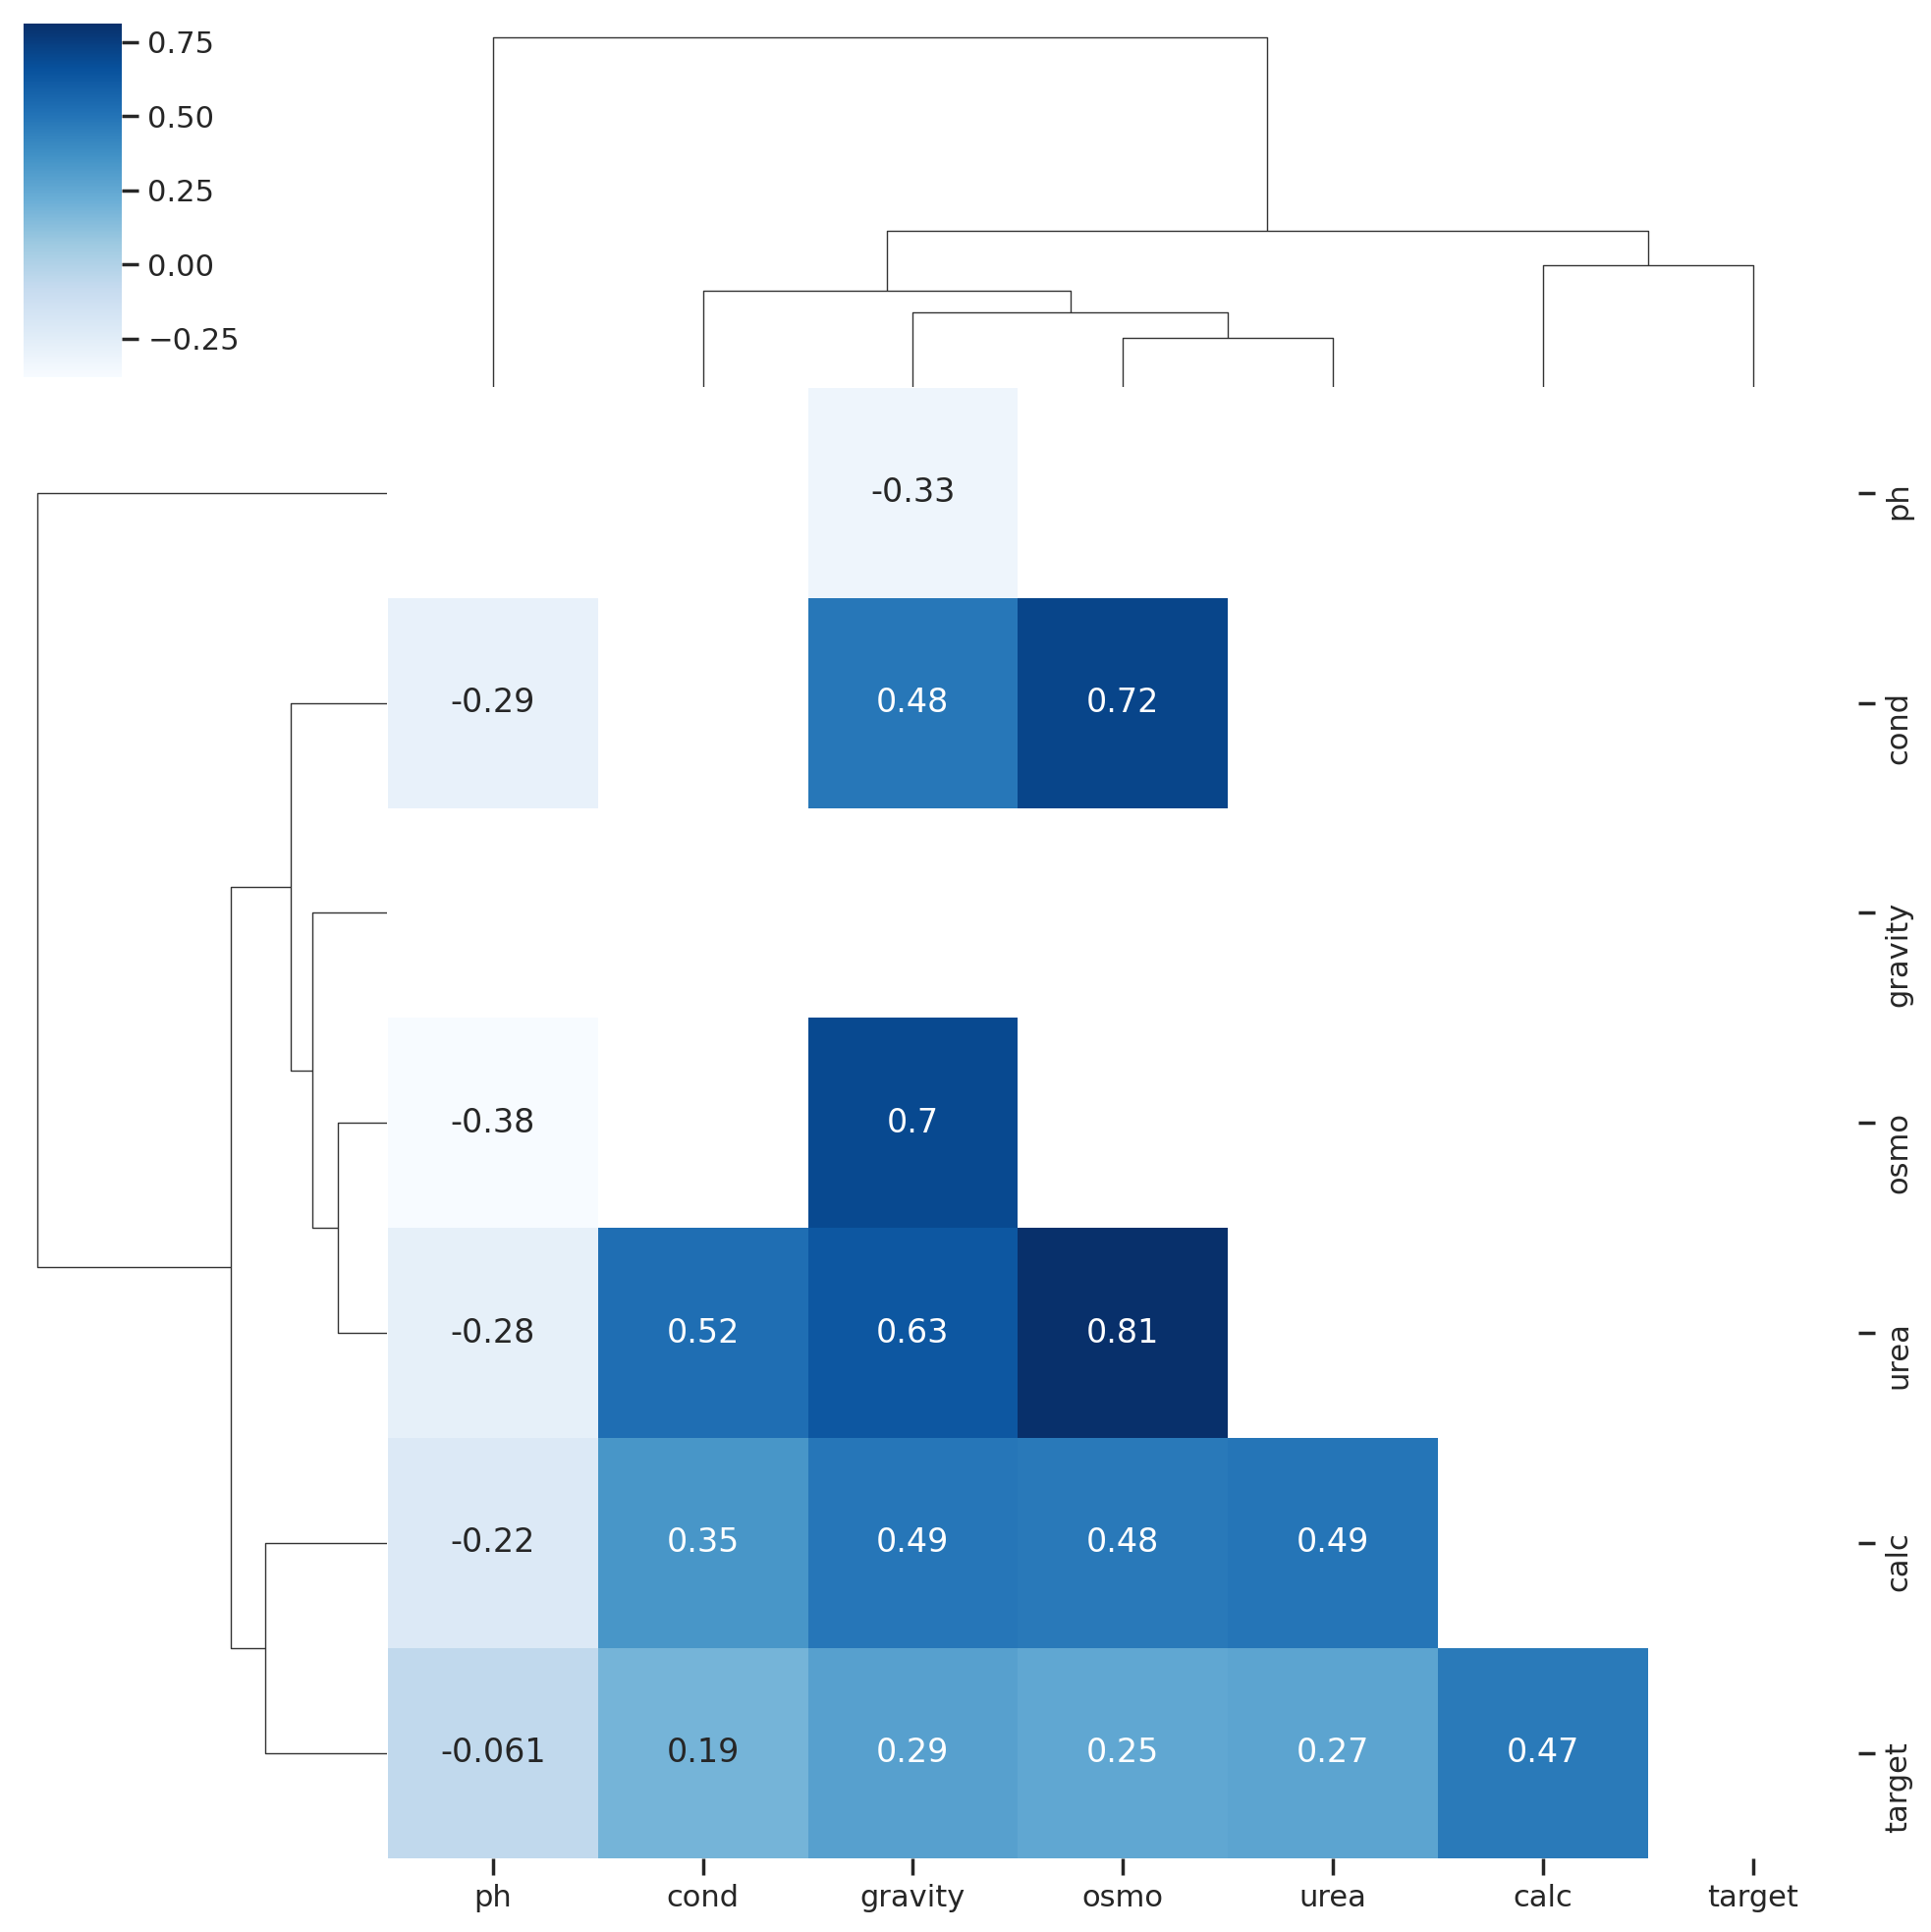

In [67]:
df_train_corr = df_train.corr()

sns.clustermap(df_train_corr, annot = True, mask = np.triu(df_train_corr), cmap="Blues")

In [68]:
df_train_corr.style.bar()

<AxesSubplot:>

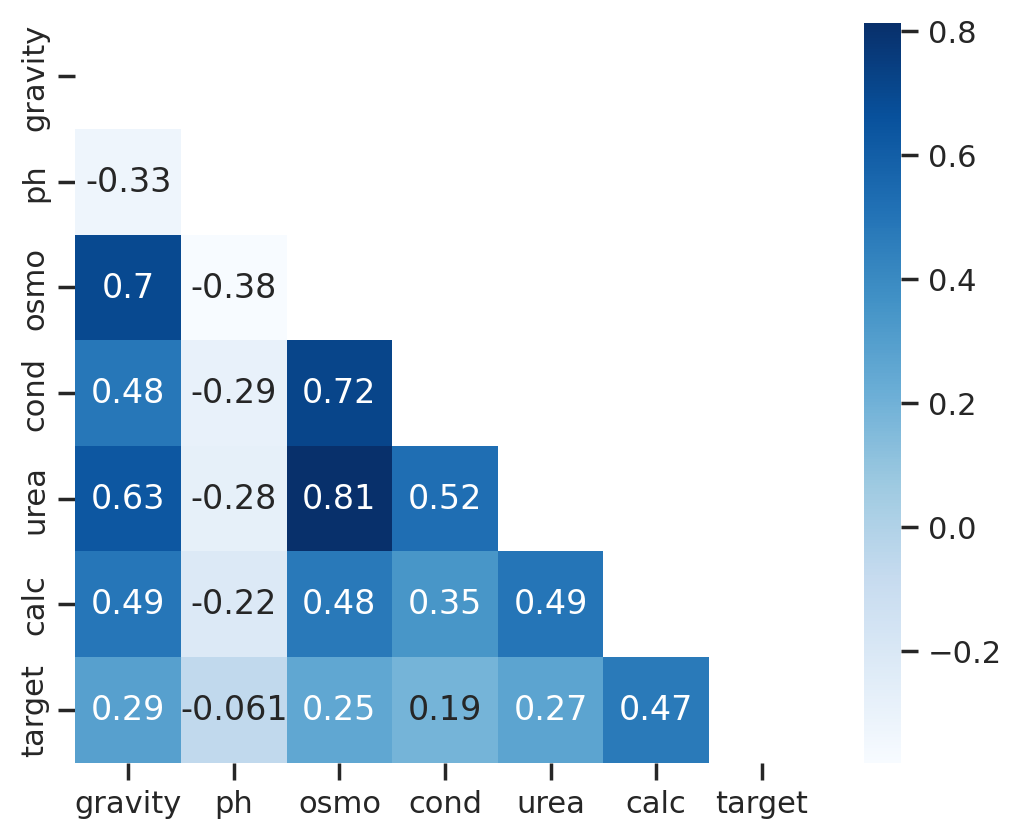

In [69]:
sns.heatmap(df_train.corr(),
            square=True,
            annot=True,
            cmap="Blues",
            mask=np.triu(df_train.corr()))

#### Drop osmo or urea?
- Urea because it is not highly correlated with any other columns
- But osmo is highly correlated with cond

In [70]:
df_train_old_2 = df_train.copy()
df_train_old_2

gravity    ph  osmo  cond  urea  calc  target
0      1.013  6.19   443  14.8   124  1.45       0
1      1.025  5.40   703  23.6   394  4.18       0
2      1.009  6.13   371  24.5   159  9.04       0
3      1.021  4.91   442  20.8   398  6.63       1
4      1.021  5.53   874  17.8   385  2.21       1
..       ...   ...   ...   ...   ...   ...     ...
409    1.011  5.21   527  21.4    75  1.53       0
410    1.024  5.53   577  19.7   224  0.77       0
411    1.018  6.28   455  22.2   270  7.68       1
412    1.008  7.12   325  12.6    75  1.03       1
413    1.011  6.13   364   9.9   159  0.27       0

[394 rows x 7 columns]

In [71]:
# df_train.drop([''])
df_train.drop("target", axis=1).apply(lambda x: x.corr(df_train.target))

gravity    0.285658
ph        -0.060781
osmo       0.253377
cond       0.185397
urea       0.267606
calc       0.474617
dtype: float64

In [72]:
df_train.columns

Index(['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc', 'target'], dtype='object')

In [73]:
#Removing urea
train_models_cv(df_train_normalized[['urea', 'calc']] , df_train_normalized['target'],  5)
X_train, X_test, y_train, y_test = train_test_split(df_train_normalized[['urea', 'calc']], df_train_normalized['target'], train_size=0.8)
train_models(X_train, X_test, y_train, y_test)

train_models_cv(df_train_normalized[['calc']] , df_train_normalized['target'],  5)
X_train, X_test, y_train, y_test = train_test_split(df_train_normalized[['calc']], df_train_normalized['target'], train_size=0.8)
train_models(X_train, X_test, y_train, y_test)

{'Decision tree': 61.67,
 'kNN': 69.78999999999999,
 'GNB': 72.32,
 'SVM': 72.06,
 'Random forests': 64.21,
 'Bagging': 63.7,
 'Ada boost': 71.31,
 'Gradient boosting': 68.01}

{'Tree': 0.569620253164557,
 'kNN': 0.620253164556962,
 'GNB': 0.6708860759493671,
 'SVM': 0.6835443037974683,
 'Random Forests': 0.5949367088607594,
 'AdaBoost': 0.6075949367088608,
 'Bagging': 0.6329113924050633,
 'Gradient boost': 0.6075949367088608}

{'Decision tree': 69.54,
 'kNN': 70.8,
 'GNB': 72.82,
 'SVM': 72.58,
 'Random forests': 68.78999999999999,
 'Bagging': 71.06,
 'Ada boost': 72.33000000000001,
 'Gradient boosting': 71.57}

{'Tree': 0.6582278481012658,
 'kNN': 0.7974683544303798,
 'GNB': 0.759493670886076,
 'SVM': 0.8227848101265823,
 'Random Forests': 0.7215189873417721,
 'AdaBoost': 0.7974683544303798,
 'Bagging': 0.7215189873417721,
 'Gradient boost': 0.759493670886076}

In [74]:
train_models_cv(df_train_standard[['calc']] , df_train_standard['target'],  5)
X_train, X_test, y_train, y_test = train_test_split(df_train_standard[['calc']], df_train_standard['target'], train_size=0.8)
train_models(X_train, X_test, y_train, y_test)

{'Decision tree': 69.54,
 'kNN': 70.8,
 'GNB': 72.82,
 'SVM': 72.58,
 'Random forests': 69.8,
 'Bagging': 70.3,
 'Ada boost': 72.33000000000001,
 'Gradient boosting': 71.57}

{'Tree': 0.6582278481012658,
 'kNN': 0.6708860759493671,
 'GNB': 0.7341772151898734,
 'SVM': 0.7721518987341772,
 'Random Forests': 0.6582278481012658,
 'AdaBoost': 0.7848101265822784,
 'Bagging': 0.6708860759493671,
 'Gradient boost': 0.6835443037974683}

In [75]:
scores_normalized

Normalized - CV  Normalized - train-test-split
Decision Tree                64.71                          65.82
kNN                          71.05                          73.42
GNB                          66.49                          72.15
SVM                          73.09                          82.28
Random forests               69.79                          74.68
Bagging                      72.84                          74.68
Ada Boost                    68.78                          70.89
Gradient Boosting            68.27                          73.42

# Submission

In [76]:
scores_total = pd.concat([scores, scores_normalized, scores_standard], axis=1)
scores_total

Plain - CV  Plain - train-test-split  Normalized - CV  \
Decision Tree           64.45                     59.49            64.71   
kNN                     59.89                     55.70            71.05   
GNB                     67.50                     73.42            66.49   
SVM                     62.42                     65.82            73.09   
Random forests          70.29                     69.62            69.79   
Bagging                 69.04                     70.89            72.84   
Ada Boost               68.78                     74.68            68.78   
Gradient Boosting       68.52                     65.82            68.27   

                   Normalized - train-test-split  Standardized - CV  \
Decision Tree                              65.82              63.96   
kNN                                        73.42              70.29   
GNB                                        72.15              66.49   
SVM                                        82.28              72.84   
Random forests                             74.68              70.80   
Bagging                                    74.68              69.80   
Ada Boost                                  70.89              68.78   
Gradient Boosting                          73.42              68.52   

                   Standardized - train-test-split  
Decision Tree                                67.09  
kNN                                          79.75  
GNB                                          77.22  
SVM                                          75.95  
Random forests                               75.95  
Bagging                                      69.62  
Ada Boost                                    73.42  
Gradient Boosting                            70.89

In [77]:
clf_svm_2 = SVC(probability=True)
clf_svm_2.fit(X_train_normalized, y_train_normalized)
clf_svm_2.score(X_test_normalized, y_test_normalized)

SVC(probability=True)

0.8227848101265823

In [78]:
df_test = pd.read_csv('/kaggle/input/playground-series-s3e12/test.csv')
df_test_normalized = df_test.copy()
df_test_normalized

id  gravity    ph  osmo  cond  urea   calc
0    414    1.017  5.24   345  11.5   152   1.16
1    415    1.020  5.68   874  29.0   385   3.46
2    416    1.024  5.36   698  19.5   354  13.00
3    417    1.020  5.33   668  25.3   252   3.46
4    418    1.011  5.87   567  29.0   457   2.36
..   ...      ...   ...   ...   ...   ...    ...
271  685    1.029  6.27   853  21.4   364   7.31
272  686    1.012  5.62   410  14.0   195   1.45
273  687    1.031  5.68   874  29.0   380   4.49
274  688    1.019  5.47   543  21.4   170   1.64
275  689    1.017  6.19   698  29.0   252   3.53

[276 rows x 7 columns]

In [79]:
df_test_normalized = MinMaxScaler().fit_transform(df_test_normalized)
df_test_normalized = pd.DataFrame(df_test_normalized)
df_test_normalized.columns = df_test.columns 
df_test_normalized

id   gravity        ph      osmo      cond      urea      calc
0    0.000000  0.413793  0.111842  0.150620  0.194529  0.158273  0.069866
1    0.003636  0.517241  0.256579  0.654909  0.726444  0.577338  0.232181
2    0.007273  0.655172  0.151316  0.487131  0.437690  0.521583  0.905434
3    0.010909  0.517241  0.141447  0.458532  0.613982  0.338129  0.232181
4    0.014545  0.206897  0.319079  0.362250  0.726444  0.706835  0.154552
..        ...       ...       ...       ...       ...       ...       ...
271  0.985455  0.827586  0.450658  0.634890  0.495441  0.539568  0.503881
272  0.989091  0.241379  0.236842  0.212583  0.270517  0.235612  0.090332
273  0.992727  0.896552  0.256579  0.654909  0.726444  0.568345  0.304869
274  0.996364  0.482759  0.187500  0.339371  0.495441  0.190647  0.103740
275  1.000000  0.413793  0.424342  0.487131  0.726444  0.338129  0.237121

[276 rows x 7 columns]

In [80]:
submission_svm_normalized = pd.DataFrame({
    "id" : df_test['id'],
    "target" : clf_svm_2.predict_proba(df_test_normalized.drop(['id'], axis = 1))[:,1]
})
submission_svm_normalized

id    target
0    414  0.231429
1    415  0.318718
2    416  0.733372
3    417  0.352341
4    418  0.221926
..   ...       ...
271  685  0.846002
272  686  0.213377
273  687  0.375930
274  688  0.236719
275  689  0.416780

[276 rows x 2 columns]

In [81]:
from sklearn.model_selection import GridSearchCV

parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[0.001, 0.01, 0.1, 0.5, 0.75, 1, 2, 5, 10, 100, 1000]}
clf_svm_3_normalized = GridSearchCV(SVC(probability=True), parameters)
clf_svm_3_normalized.fit(df_train_normalized.drop(['target'], axis=1), df_train_normalized['target'])

# GridSearchCV(estimator=SVC(probability=True),
#              param_grid={'C': [0.001, 0.01, 0.1, 0.5, 0.75, 1, 2, 5, 10, 100, 1000], 'kernel': ('linear', 'rbf', 'poly')})
clf_svm_3_normalized.best_params_
clf_svm_3_normalized.best_score_

GridSearchCV(estimator=SVC(probability=True),
             param_grid={'C': [0.001, 0.01, 0.1, 0.5, 0.75, 1, 2, 5, 10, 100,
                               1000],
                         'kernel': ('linear', 'rbf', 'poly')})

{'C': 0.5, 'kernel': 'rbf'}

0.7384615384615385

In [82]:
submission_svm_normalized_with_hyperparameter = pd.DataFrame({
    "id" : df_test['id'],
    "target" : clf_svm_3_normalized.predict_proba(df_test_normalized.drop(['id'], axis = 1))[:,1]
})
submission_svm_normalized_with_hyperparameter

id    target
0    414  0.233068
1    415  0.340510
2    416  0.801306
3    417  0.371737
4    418  0.235192
..   ...       ...
271  685  0.841713
272  686  0.190625
273  687  0.417263
274  688  0.232089
275  689  0.392283

[276 rows x 2 columns]